In [28]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.stats import lognorm,norm
from scipy import stats

import pandas as pd

In [2]:

# parameters for viral dynamics model
#do the population simulations

#parameters for simulations
#cellular parameters
thL = 5.2e-4
aL  = 0.015; 
dA  = 1.0
xi  = 0.0001; 
aS  = 1e8          # constant growth rate of suseceptible cells
dS  = 0.03         # death rate of suseceptible cells
Bt0 = 1e-10*0.05   # infection rate of T-cells
dI  = 1      # death rate of infected cells
pi  = 1e4    # burst rate of virus from cells
gam = 23     # virus clearance rate
mu  = 0.01   # mutation rate
tau = 1e-4

dL=aL-thL-xi #death rate
l=1-(1+xi/thL)*tau #latency factor

Seq=gam*dA/Bt0/pi/l
Leq=tau/thL*(gam*dS*dA/Bt0/pi/l-aS)
Aeq=aS*l/dA-gam*dS/Bt0/pi
Veq=aS*pi*l/gam/dA-dS/Bt0

Xeq=np.array([Seq,Leq,Aeq,Veq])

R0=aS*Bt0*pi/gam/dS/dA

print('R_0',R0)
print('ep_c',1-1/R0)

R_0 7.246376811594203
ep_c 0.862


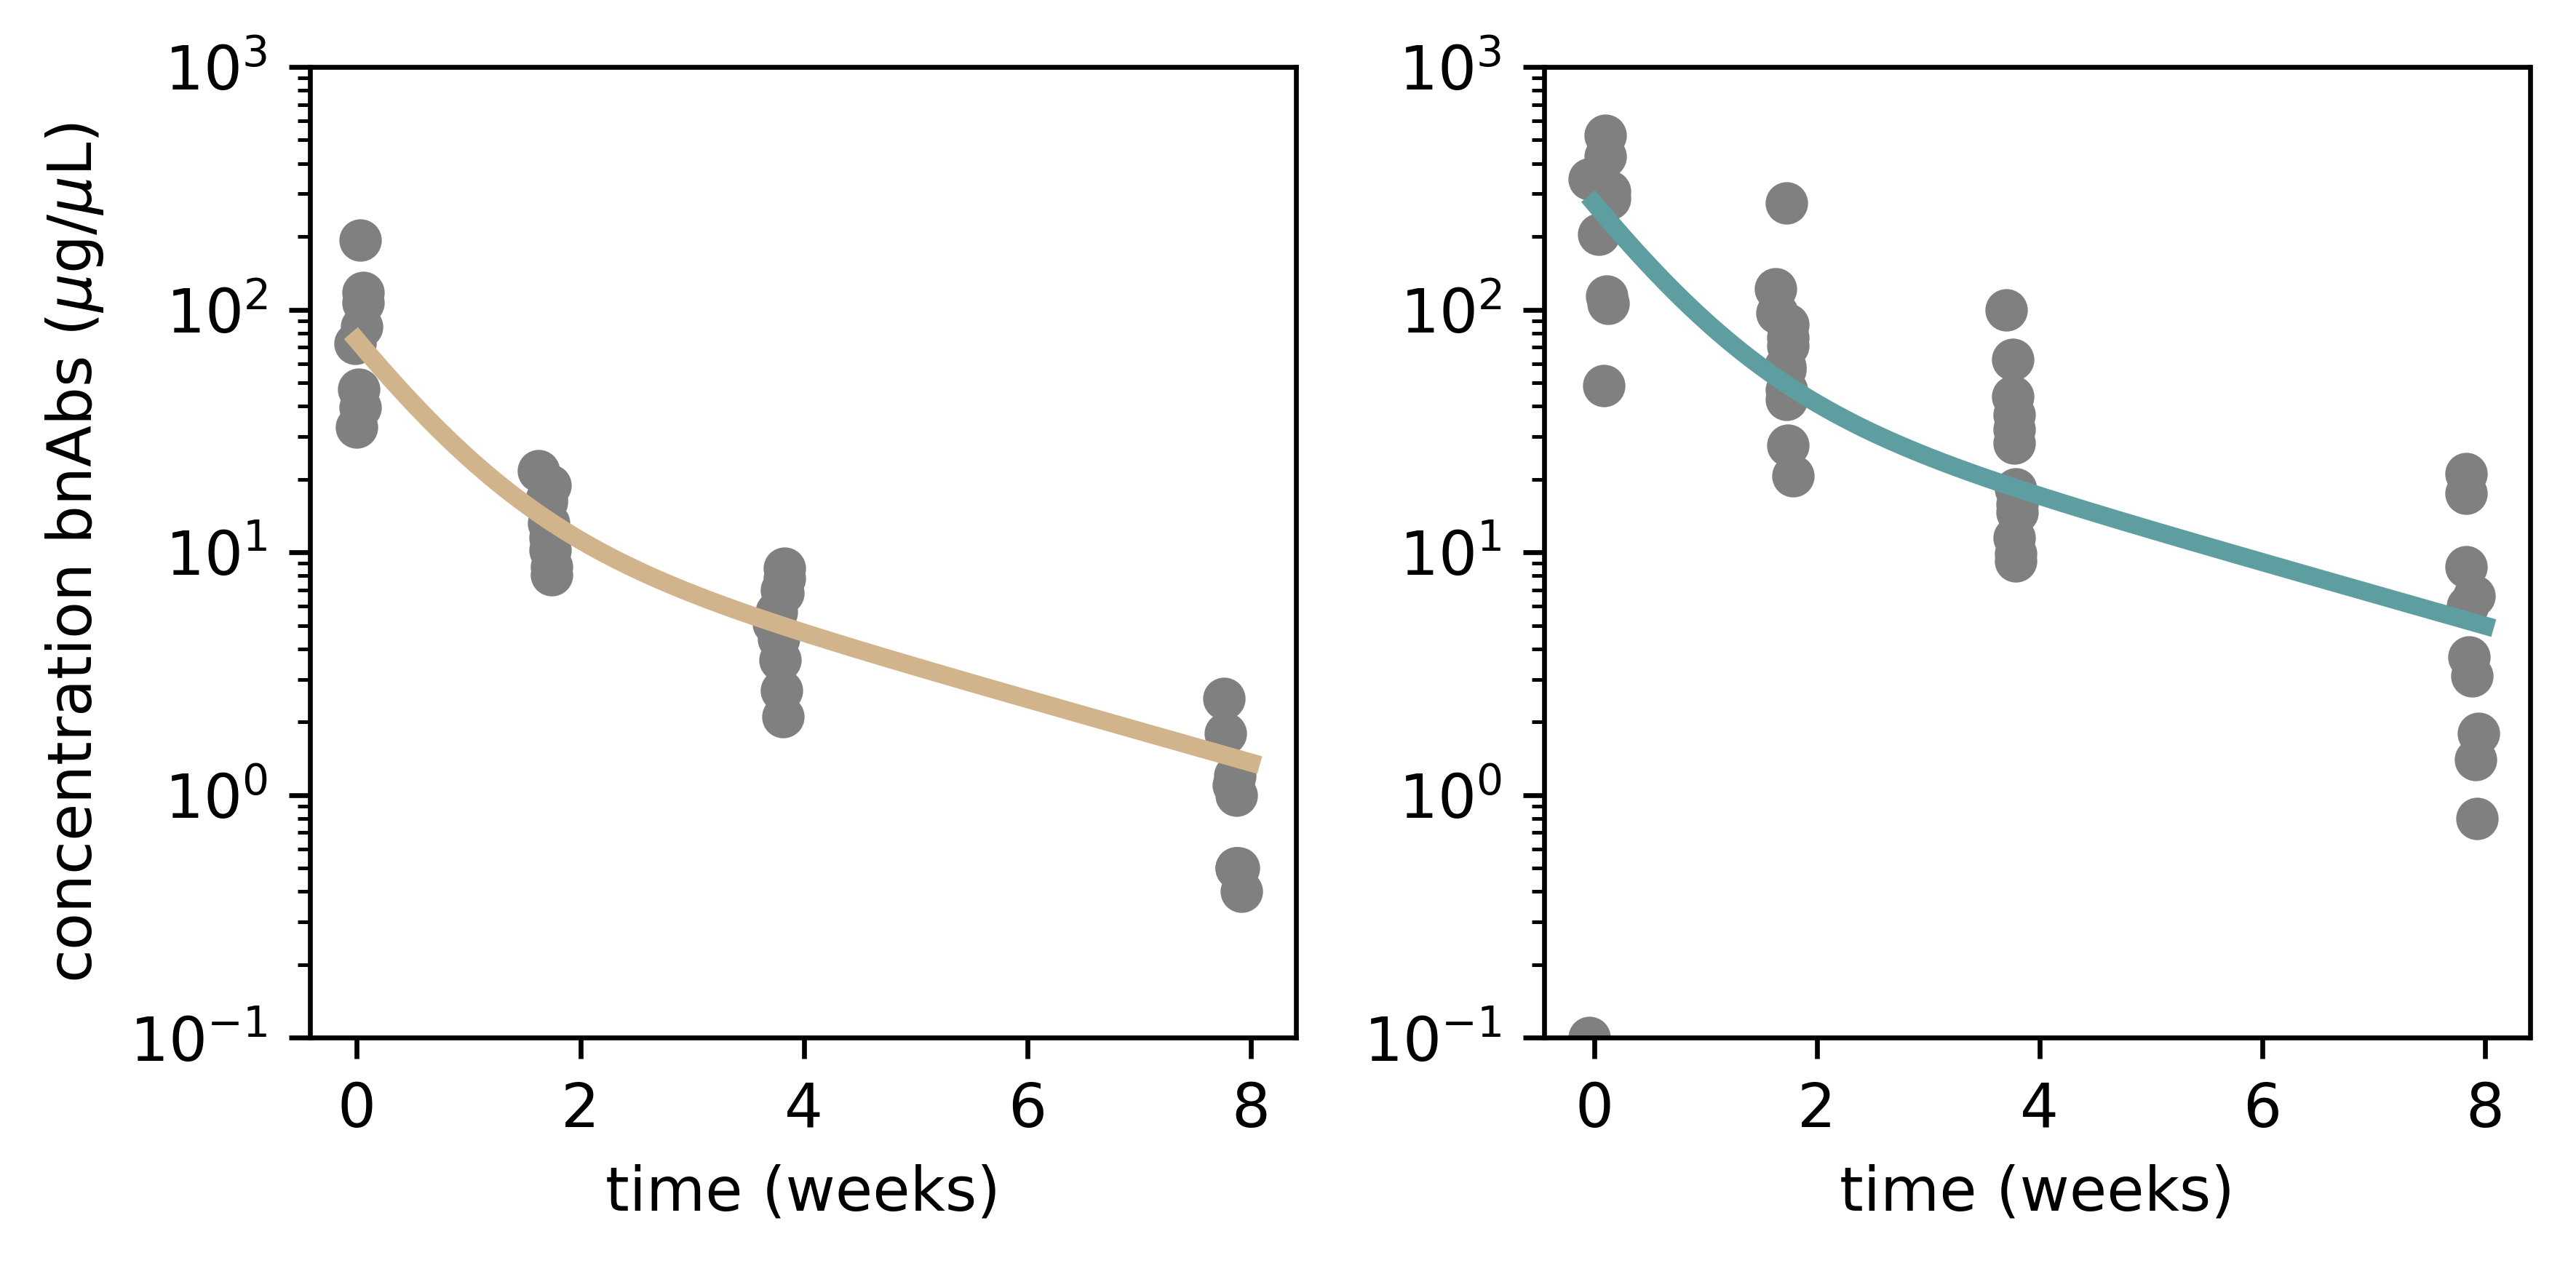

In [3]:
#show decay kinetics of Abs
def Ab_conc(c1,c2,r1,r2,t):
    return c1*np.exp(-r1*t)+c2*np.exp(-r2*t)

t=np.linspace(0,8,1e3)
c10=60
c30=220
r1=1.5
r2=0.3

plt.figure(figsize=(6,3),dpi=600)

d10=pd.read_csv('decays10.csv',names=['time','conc'])
d30=pd.read_csv('decays30.csv',names=['time','conc'])
plt.subplot(121)
plt.scatter(d10['time']/7,d10['conc'],color='gray')
plt.yscale('log')
plt.ylabel('concentration bnAbs ($\mu$g/$\mu$L)')
plt.xlabel('time (weeks)')
Ab_t10=Ab_conc(c10,c10/4,r1,r2,t)
plt.semilogy(t,Ab_t10,color='tan',lw=3)
plt.ylim([0.1,1e3])

plt.subplot(122)
plt.scatter(d30['time']/7,d30['conc'],color='gray')
plt.yscale('log')
plt.xlabel('time (weeks)')
Ab_t30=Ab_conc(c30,c30/4,r1,r2,t)
plt.semilogy(t,Ab_t30,color='cadetblue',lw=3)
plt.ylim([0.1,1e3])

plt.tight_layout()
plt.gcf().savefig('Yunda_decays.pdf')  # No warning now


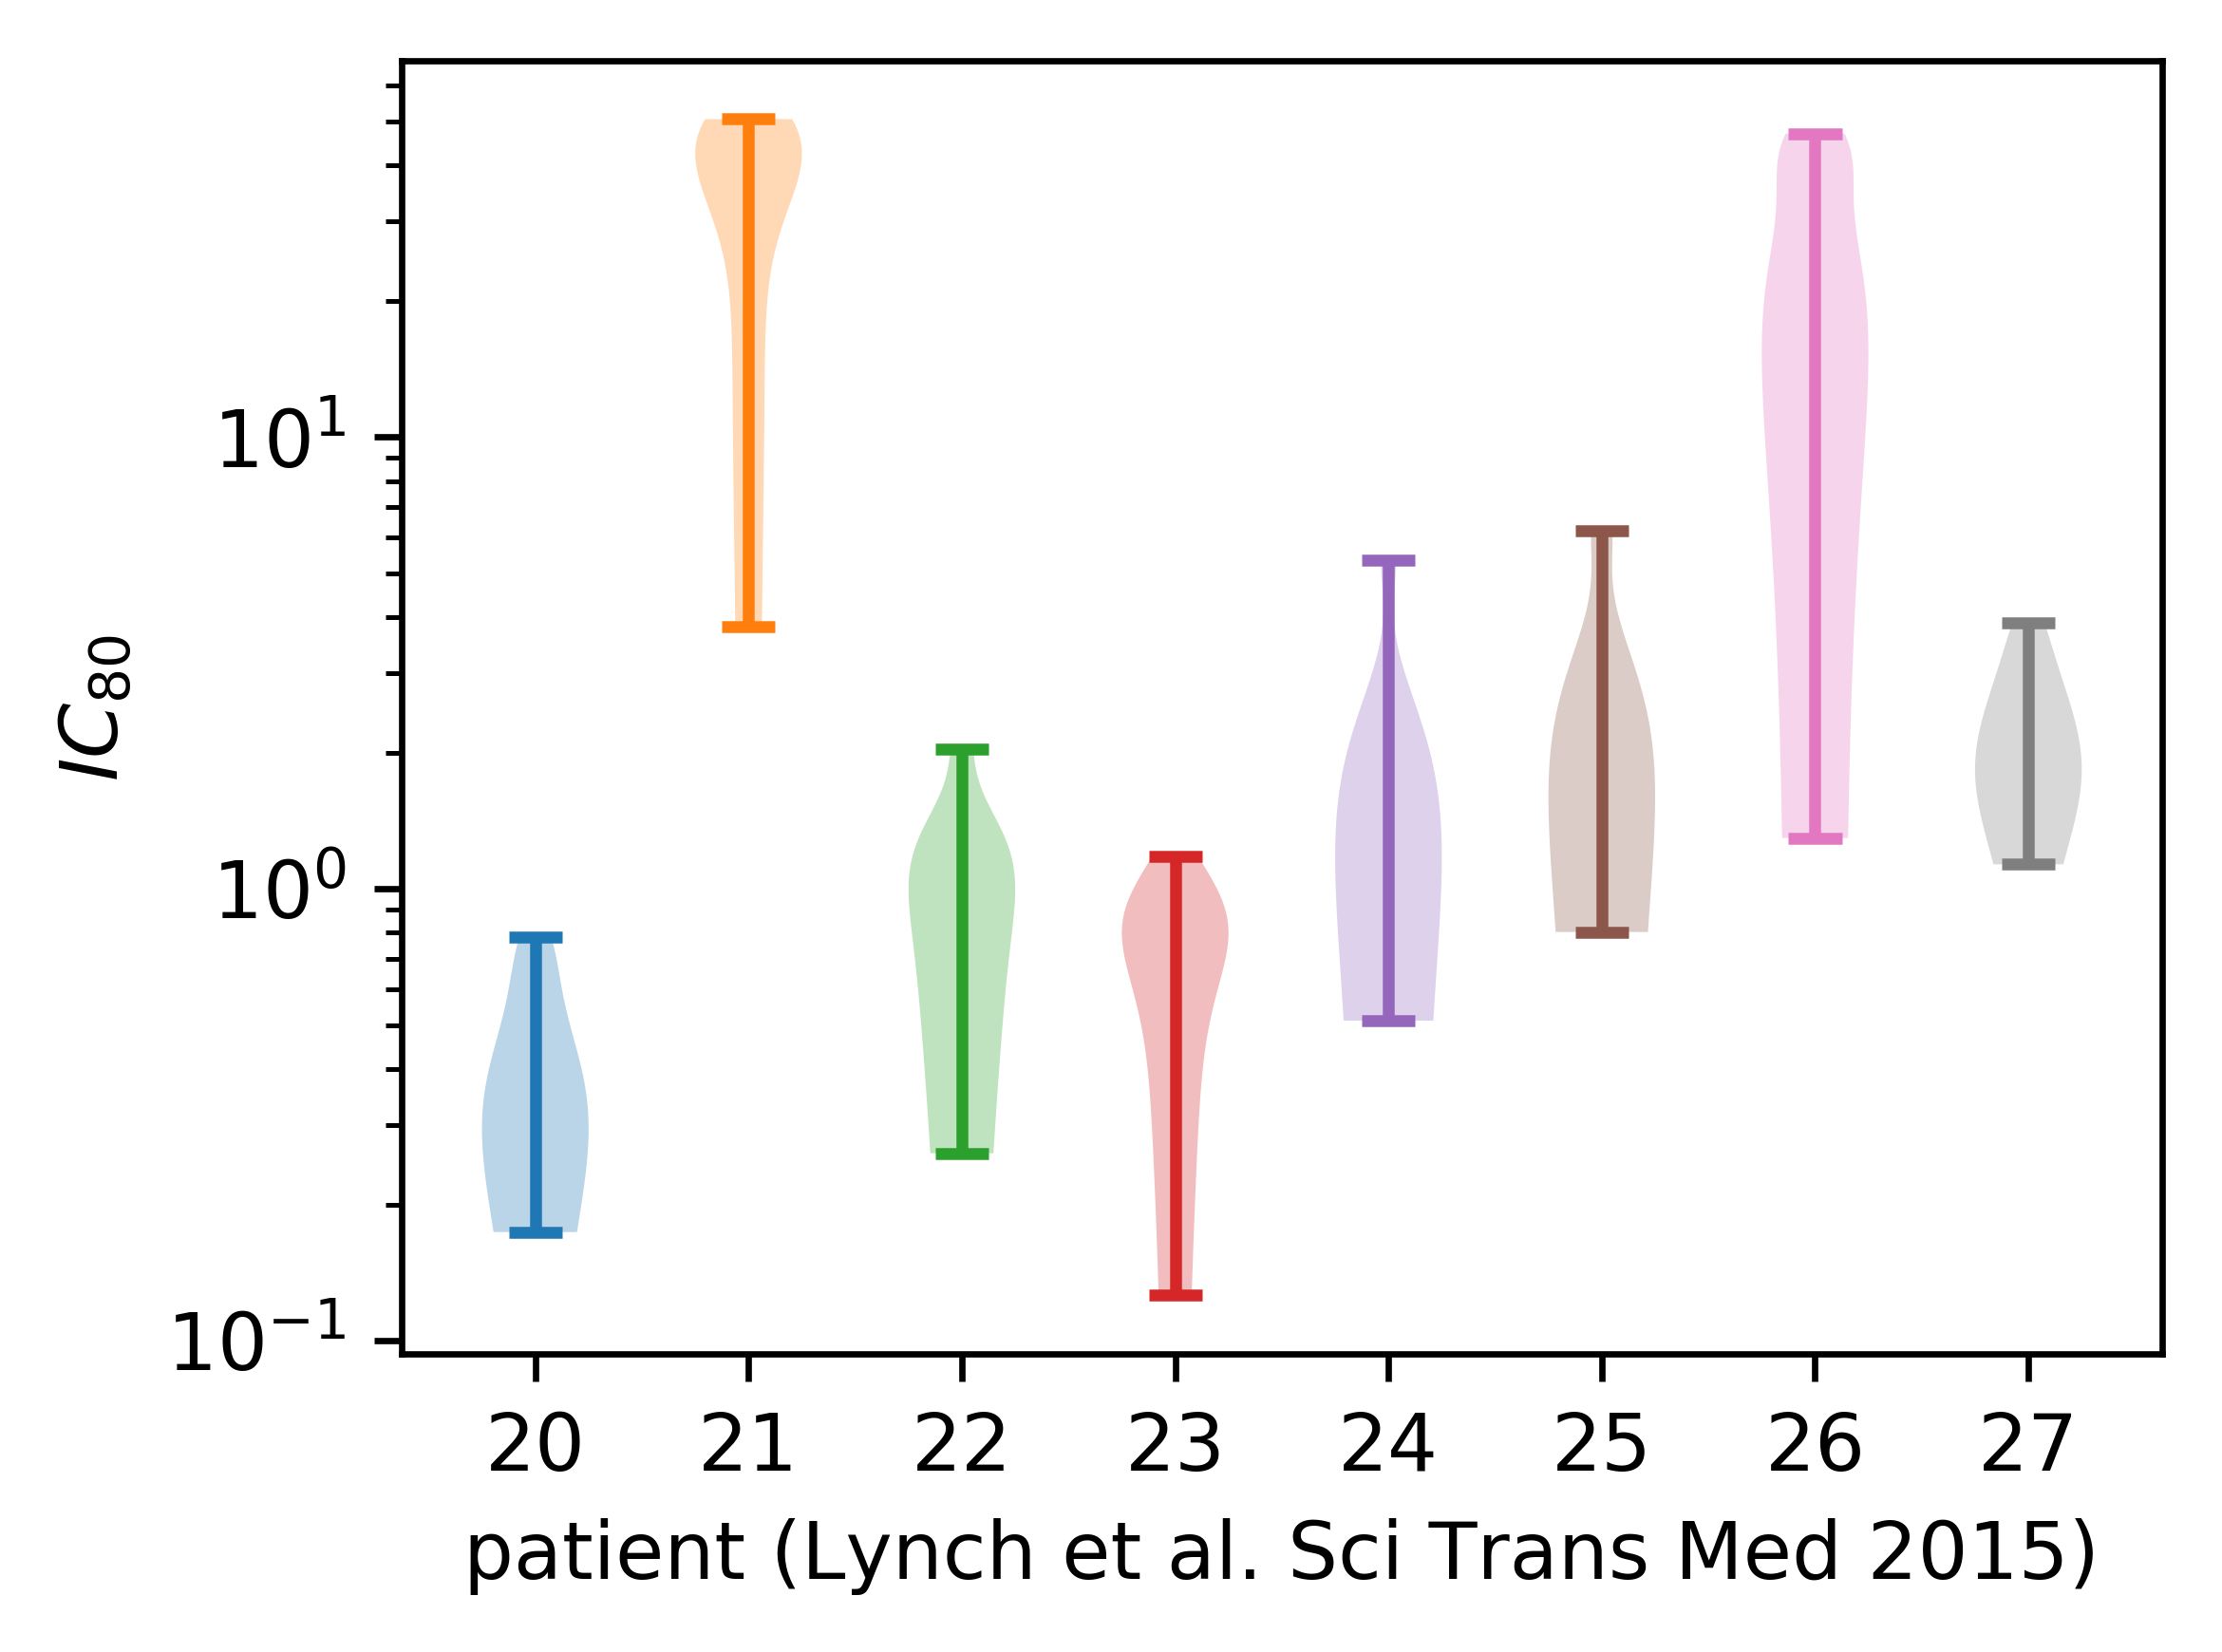

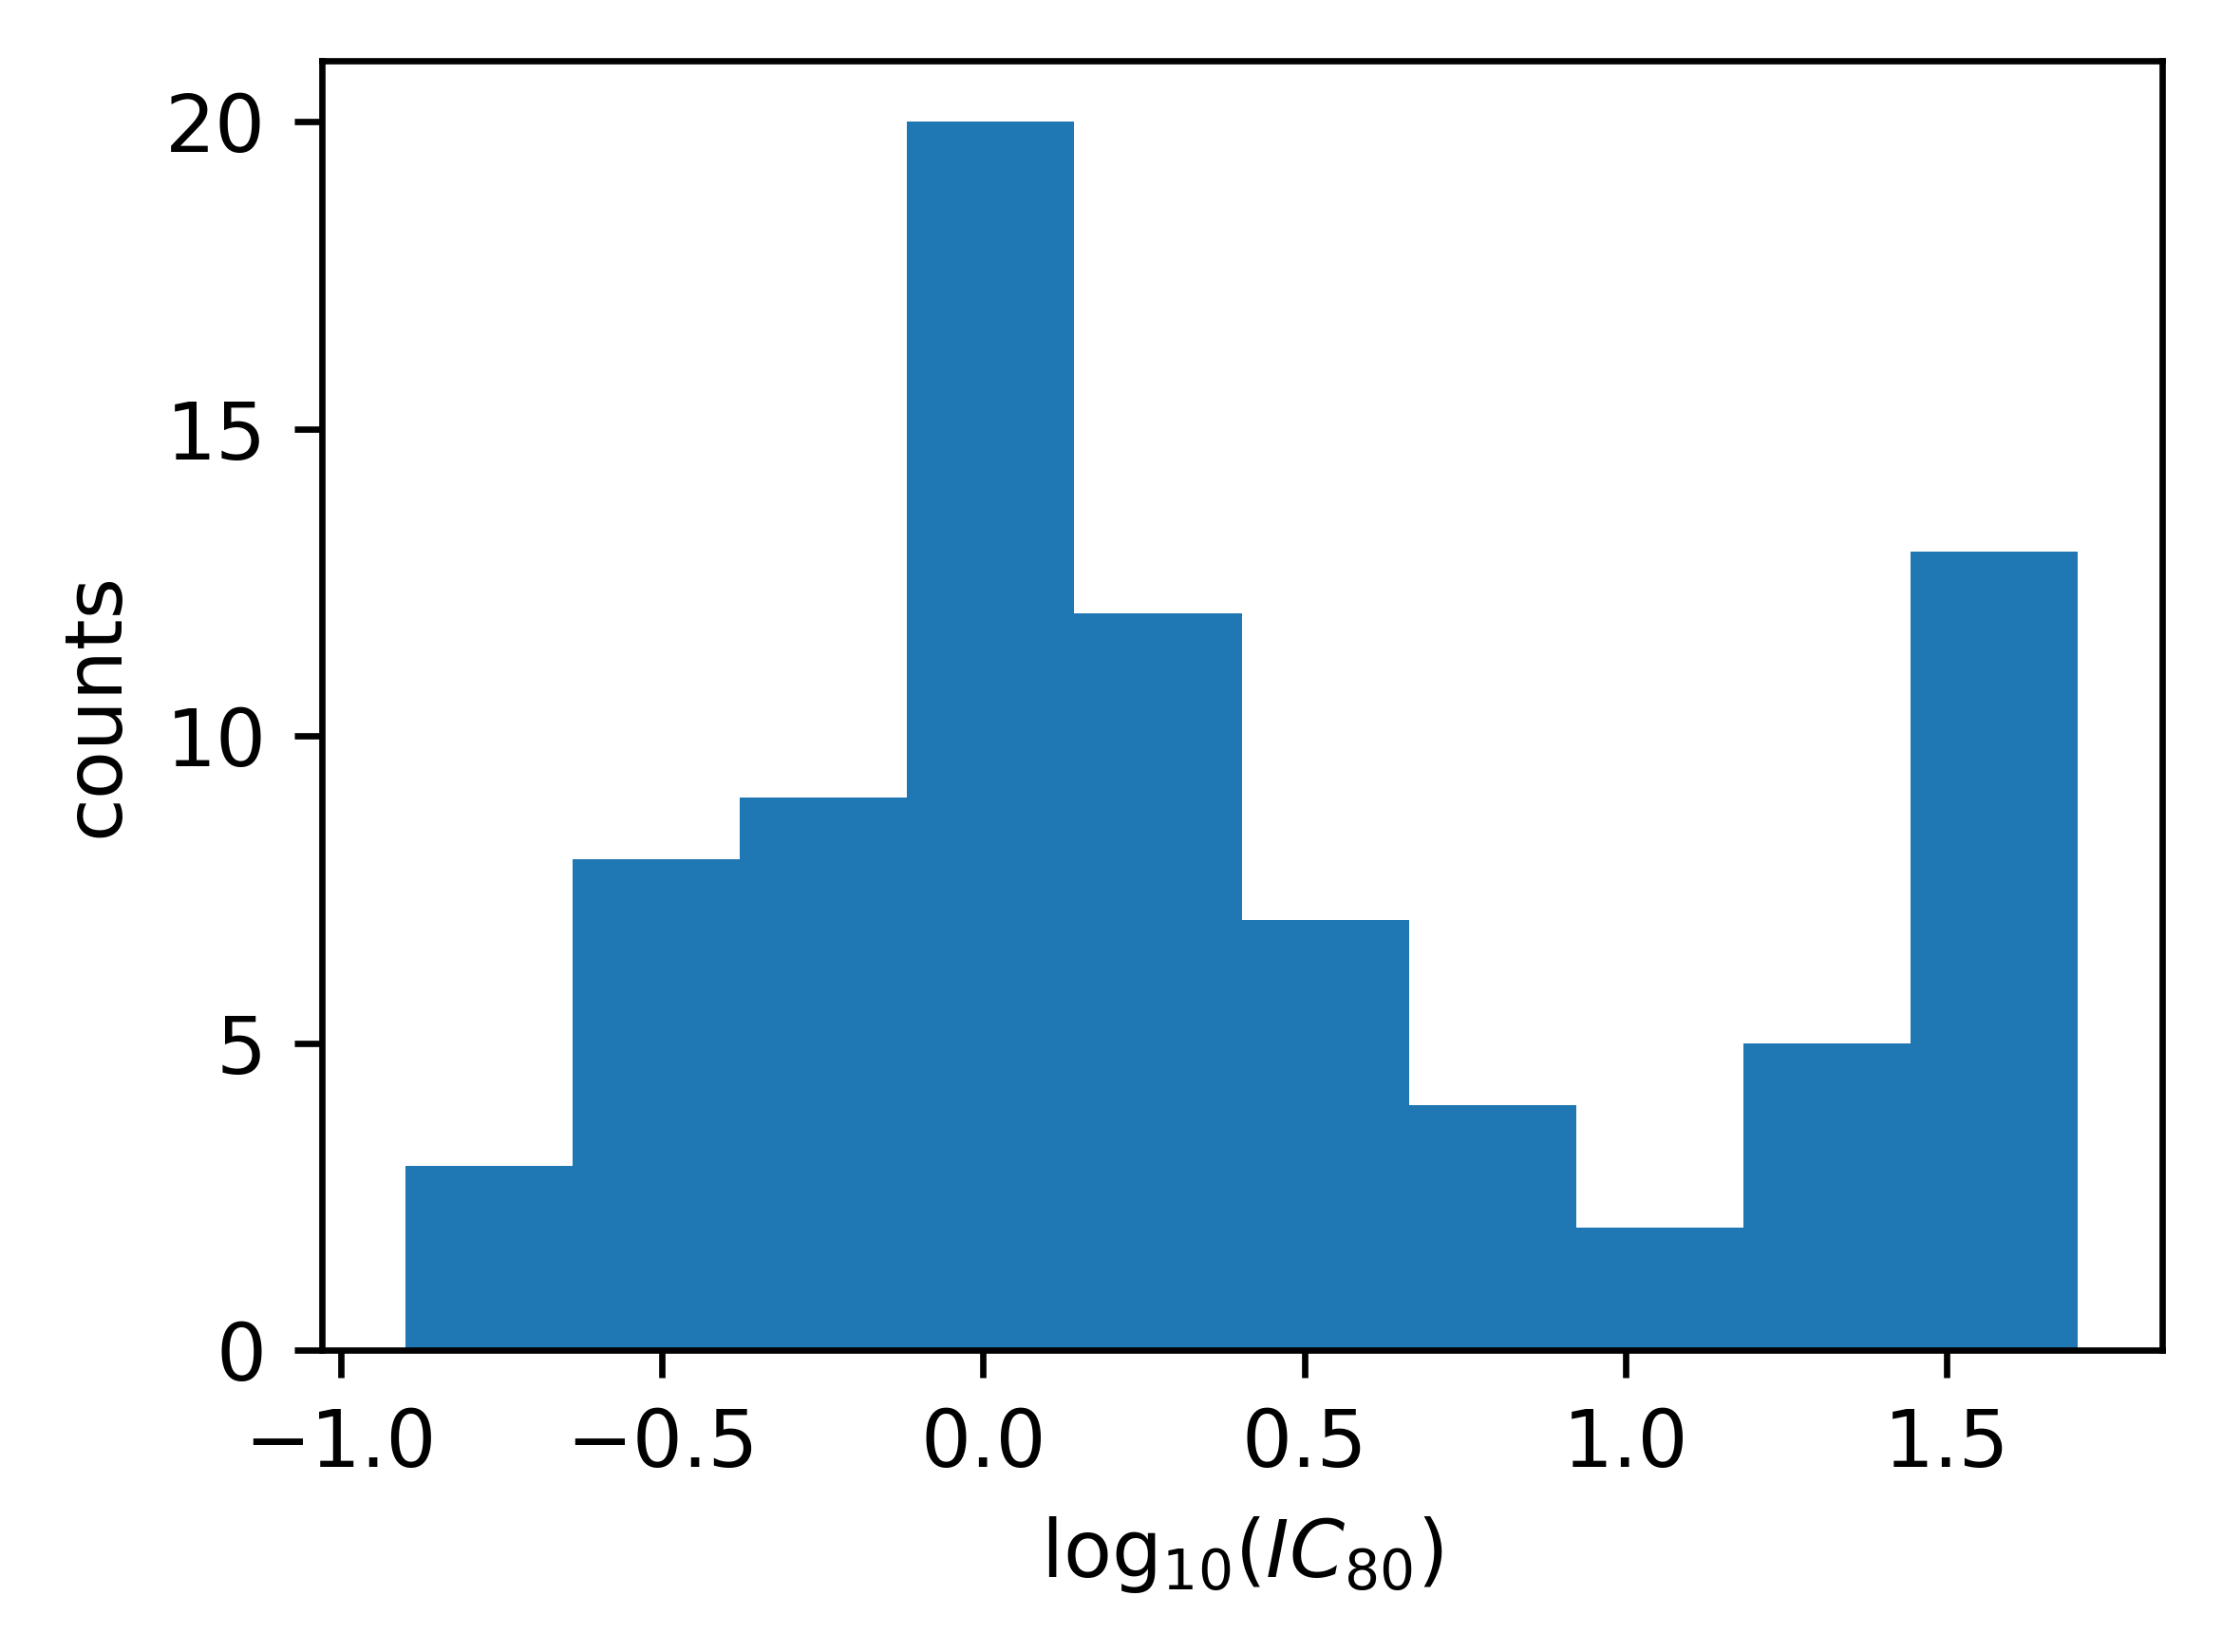

In [4]:
IC80 = np.array([
        [0.174,0.239,0.309,0.287,0.184,0.410,0.539,0.388,0.783,0.648],
        [3.801,13.967,32.949,34.874,37.982,50.565,47.721,38.042,49.204,47.176],
        [2.042,1.238,1.059,1.309,1.087,0.878,0.854,0.442,0.317,0.260],
        [0.685,0.965,1.179,0.801,0.801,0.811,1.006,0.654,0.478,0.286,0.126],
        [5.335,2.536,1.654,1.650,1.721,1.223,0.796,0.662,0.511,0.564],
        [6.206,2.486,2.705,1.551,1.322,1.052,0.803],
        [42.586,40.768,35.319,41.305,46.946,24.380,21.407,18.528,22.946,15.874,12.792,7.985,8.204,3.383,1.297],
        [2.836,3.223,3.876,2.286,2.383,1.978,1.595,1.552,1.134,1.555]])

#between patient variability in IC80
plt.figure(figsize=(4,3),dpi=600)
for i in range(8):
    plt.violinplot(IC80[i],[i])
plt.xticks(range(8),np.arange(8)+20)
plt.yscale('log')    
plt.xlabel('patient (Lynch et al. Sci Trans Med 2015)')
plt.ylabel('$IC_{80}$')
plt.tight_layout()
plt.gcf().savefig('between_patient_IC80.pdf')  # No warning now

plt.figure(figsize=(4,3),dpi=600)
plt.hist(np.log10(np.hstack(IC80)))
plt.xlabel('$\log_{10}(IC_{80})$')
plt.ylabel('counts')
plt.tight_layout()
plt.gcf().savefig('IC80_distribution.pdf')  # No warning now


 

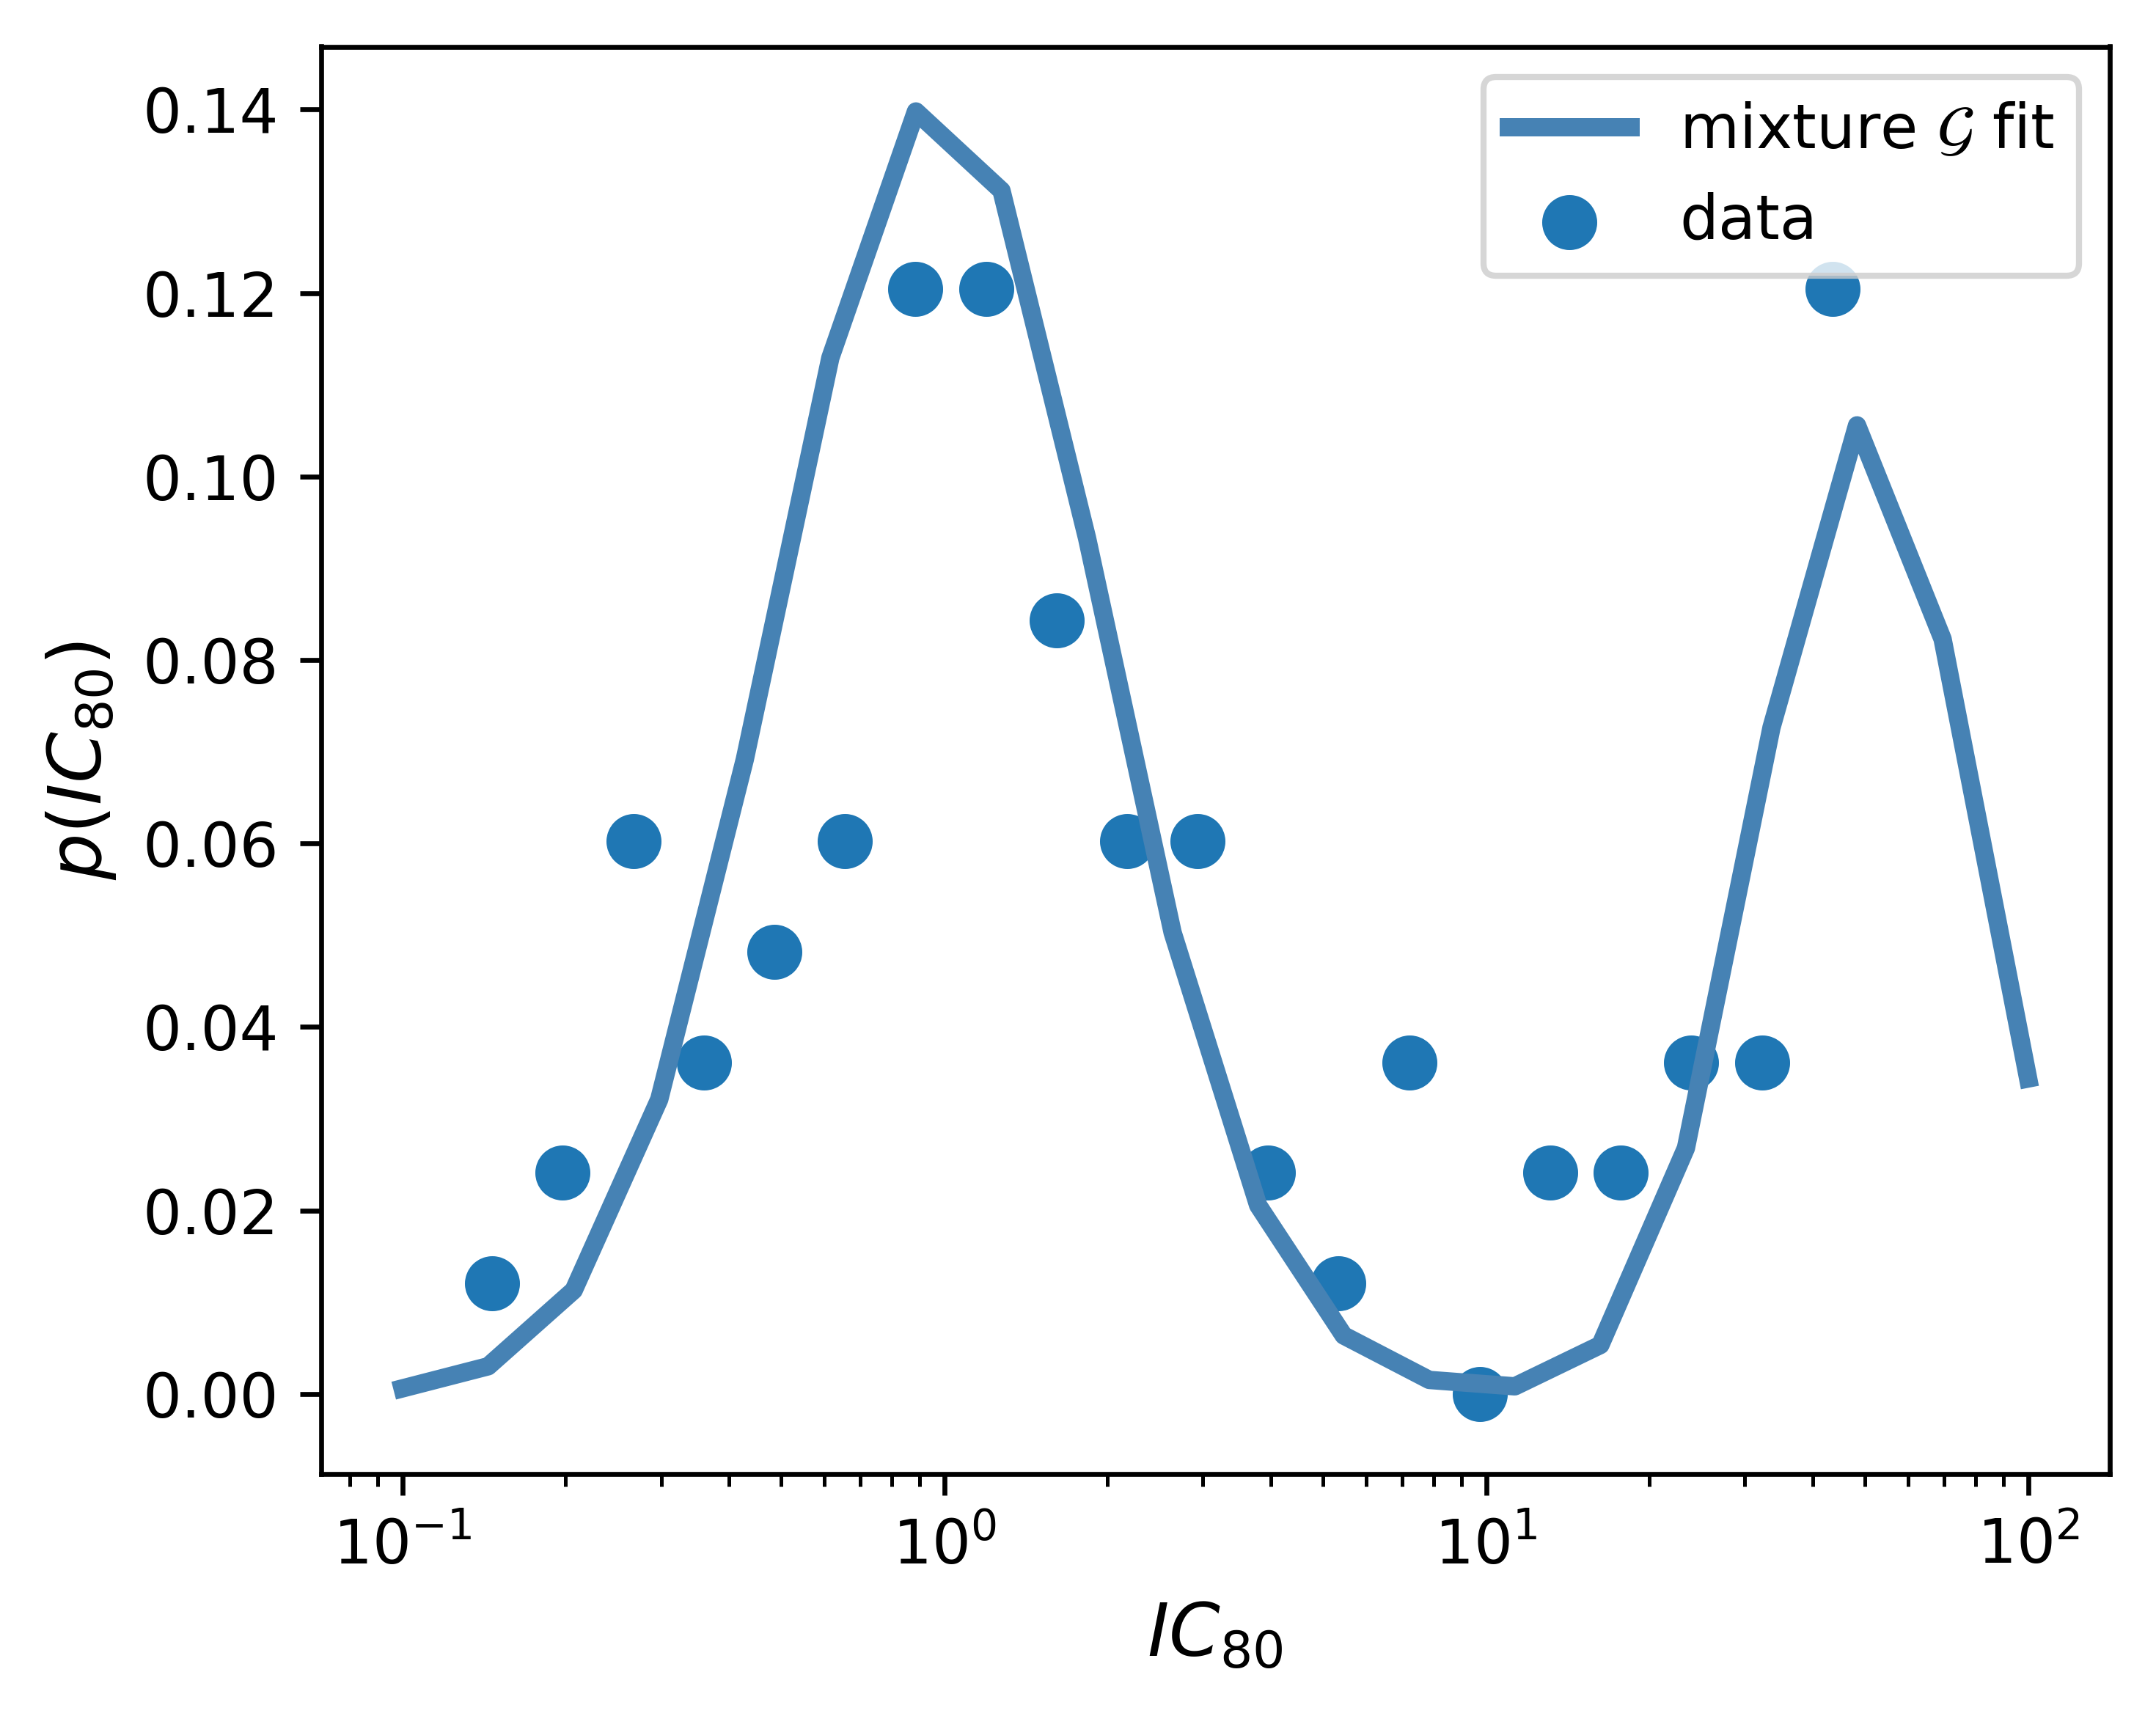

In [5]:

#trying to fit the distribution       
def func1d_pablo(x, nbins):
    histo, bin_edges = np.histogram(x,nbins)
    bin_center = 0.5*(bin_edges[1:] + bin_edges[:-1])
    return histo,bin_center

nbins=10

log80=np.log10(np.hstack(IC80))

p_x,x=func1d_pablo(log80,20)

plt.figure(figsize=(5,4),dpi=600)
    
xx=np.linspace(-1,2,len(x))
gmix=2*norm.pdf(xx, -0.01, 0.3)+norm.pdf(xx, 1.7, 0.2)
p_fit=gmix/sum(gmix)

plt.scatter(10**x,p_x/sum(p_x),lw=3)
plt.semilogx(10**xx,p_fit,lw=3,color='steelblue')

#plt.plot(x,p1/3)
#plt.plot(x,p2/5)

plt.xlabel('$IC_{80}$',fontsize=12)
plt.ylabel('$p(IC_{80})$',fontsize=12)
plt.legend([r'mixture $\mathcal{G}$ fit','data'],loc=1,fontsize=10)

plt.tight_layout()
plt.gcf().savefig('fit_dist.pdf')  # No warning now


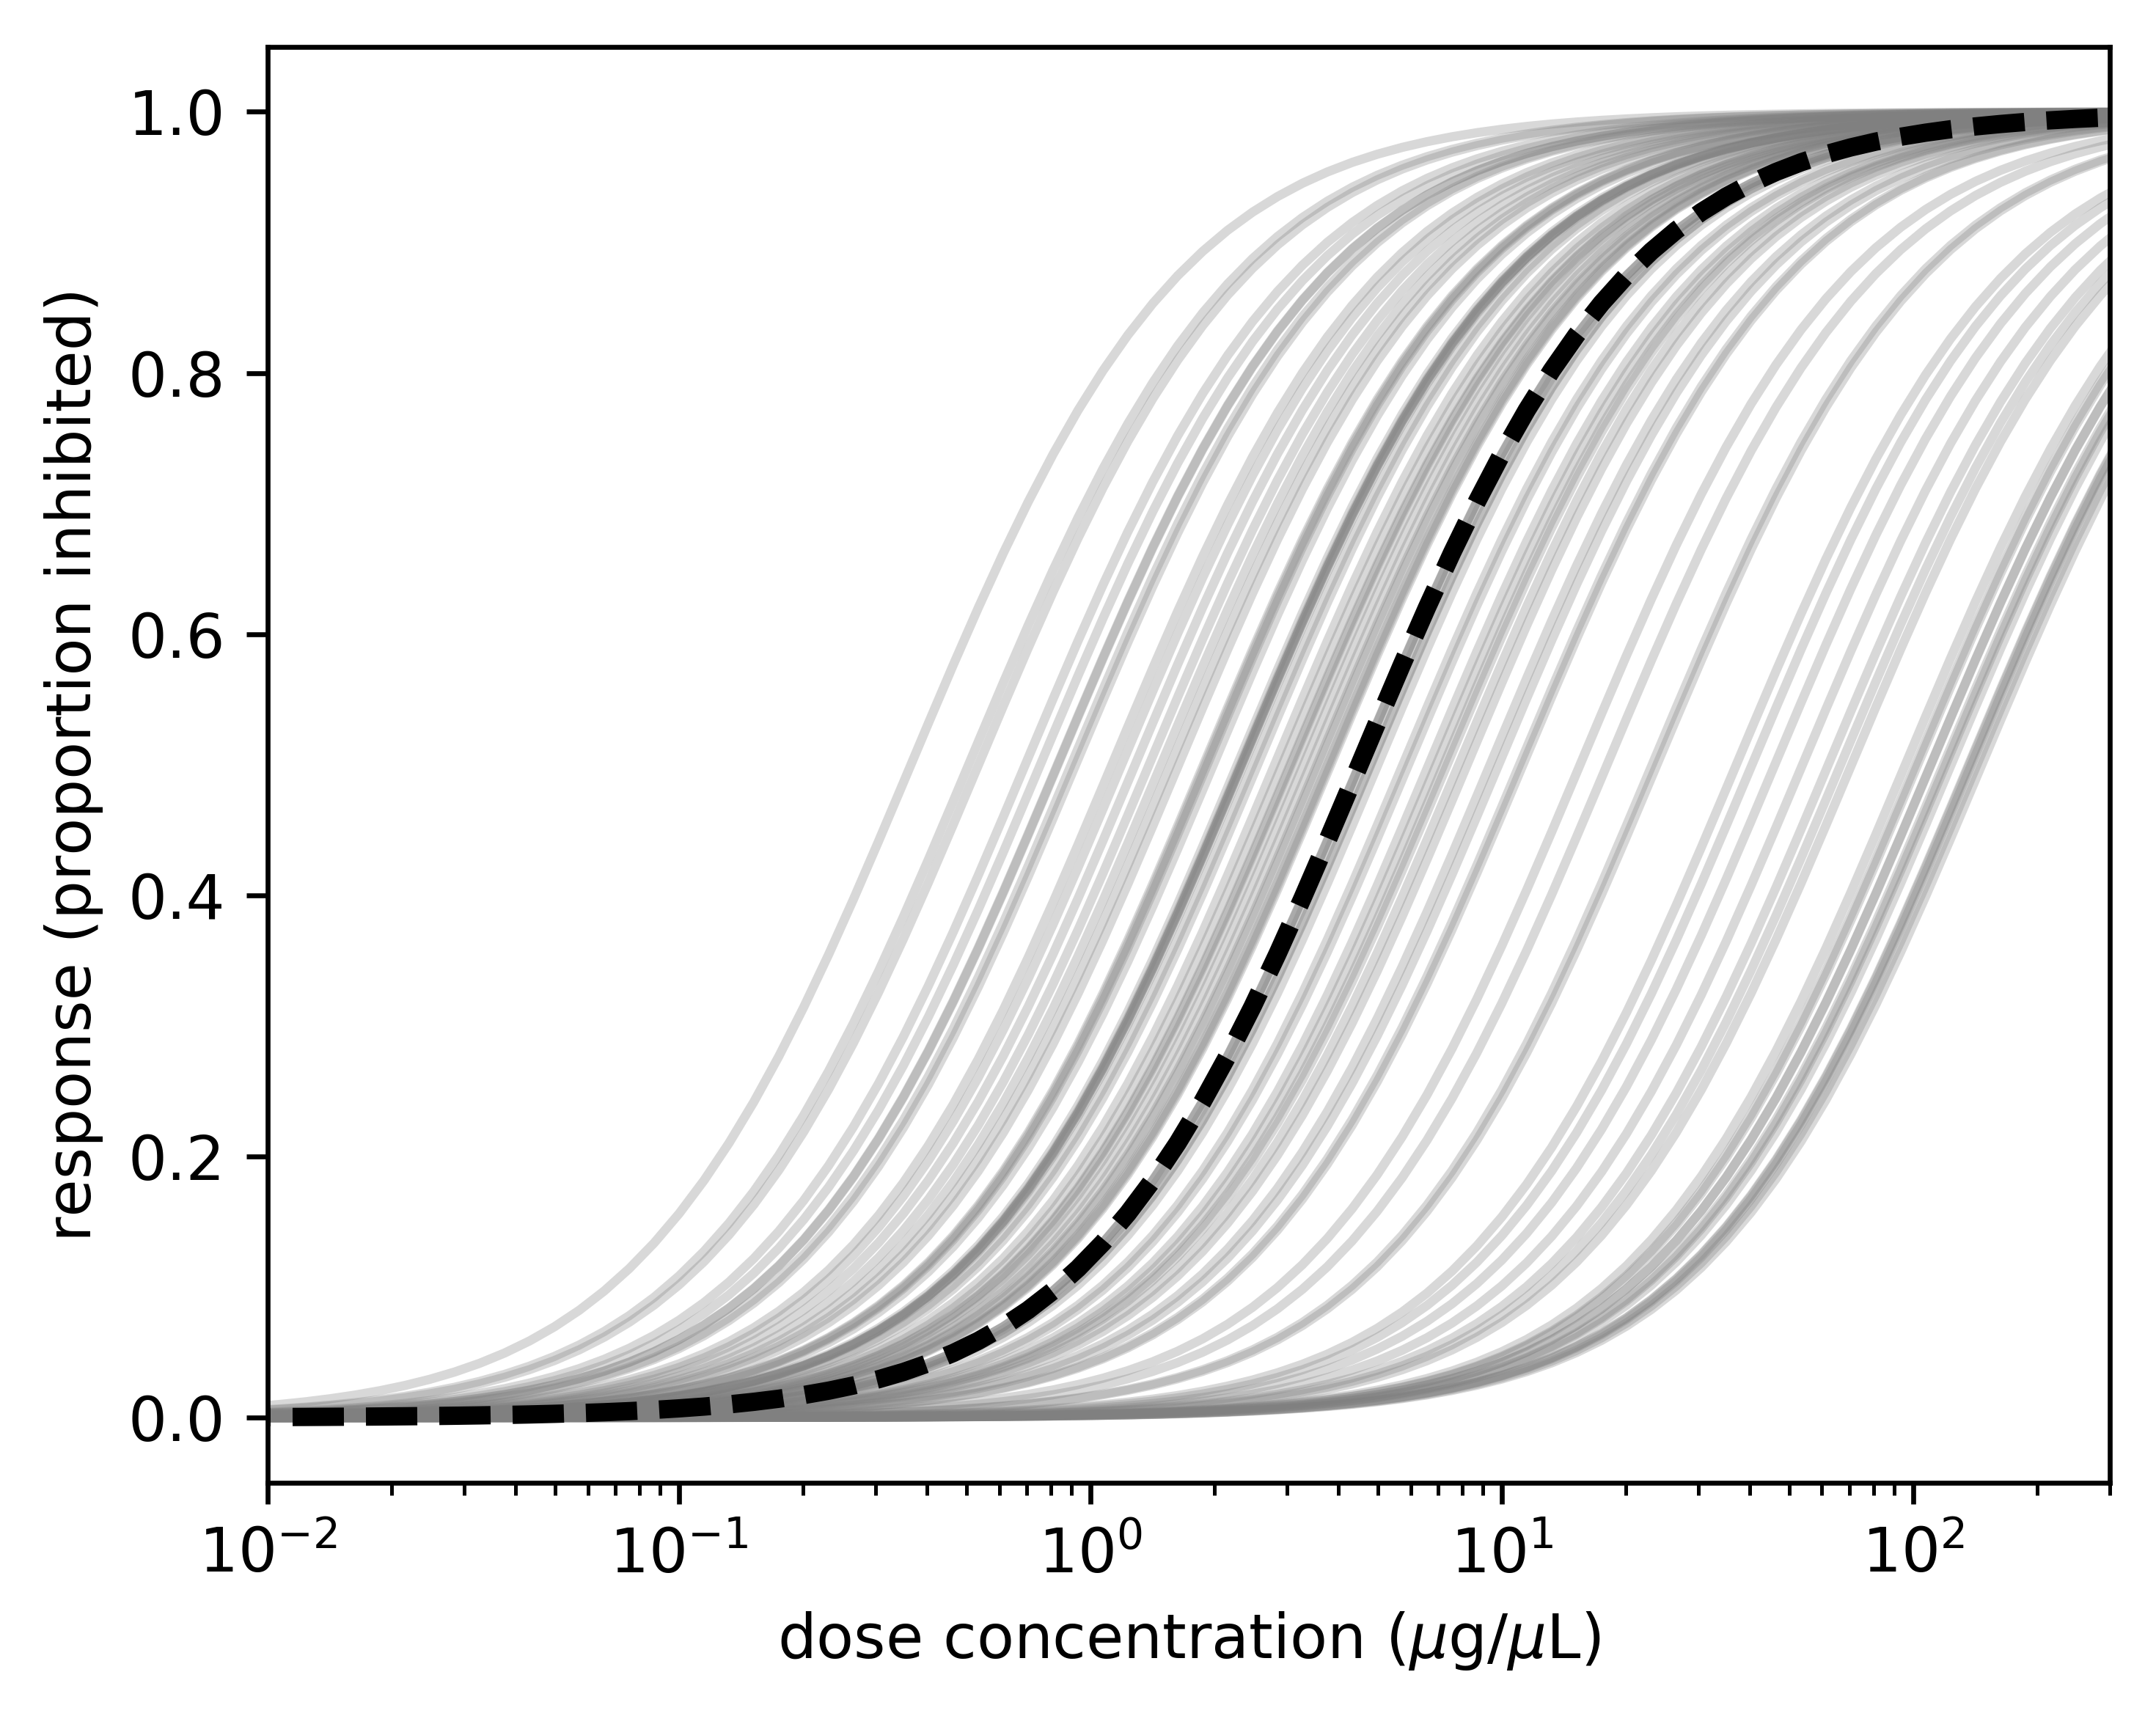

In [6]:
#functions for Ab IC80
def response80(dose,IC80):
    hill=1.3
    IC50 = IC80*4**(1/hill) 
    res = 1/(1+(dose/IC50)**-hill)
    return res

plt.figure(figsize=(5,4),dpi=600)
#data?
dose_response=pd.read_csv('vrc01_doseresponse.csv',names=['dose','response'])
#plt.scatter(dose_response['dose'],dose_response['response'])

#all from Lynch
dose=np.logspace(-3,3,100)
for i in range(len(log80)):
    plt.plot(dose,response80(dose,10**log80[i]),color='gray',alpha=0.3)

#plt.plot(dose,response80(dose,10**np.mean(log80)),color='darkgreen',lw=3,ls='--')
plt.plot(dose,response80(dose,10**np.median(log80)),color='k',lw=3,ls='--')
plt.xlabel('dose concentration ($\mu$g/$\mu$L)')
plt.ylabel('response (proportion inhibited)')
plt.xscale('log')
plt.xlim([0.01,300])

plt.tight_layout()
plt.gcf().savefig('lynchdoseresponse.pdf')  # No warning now


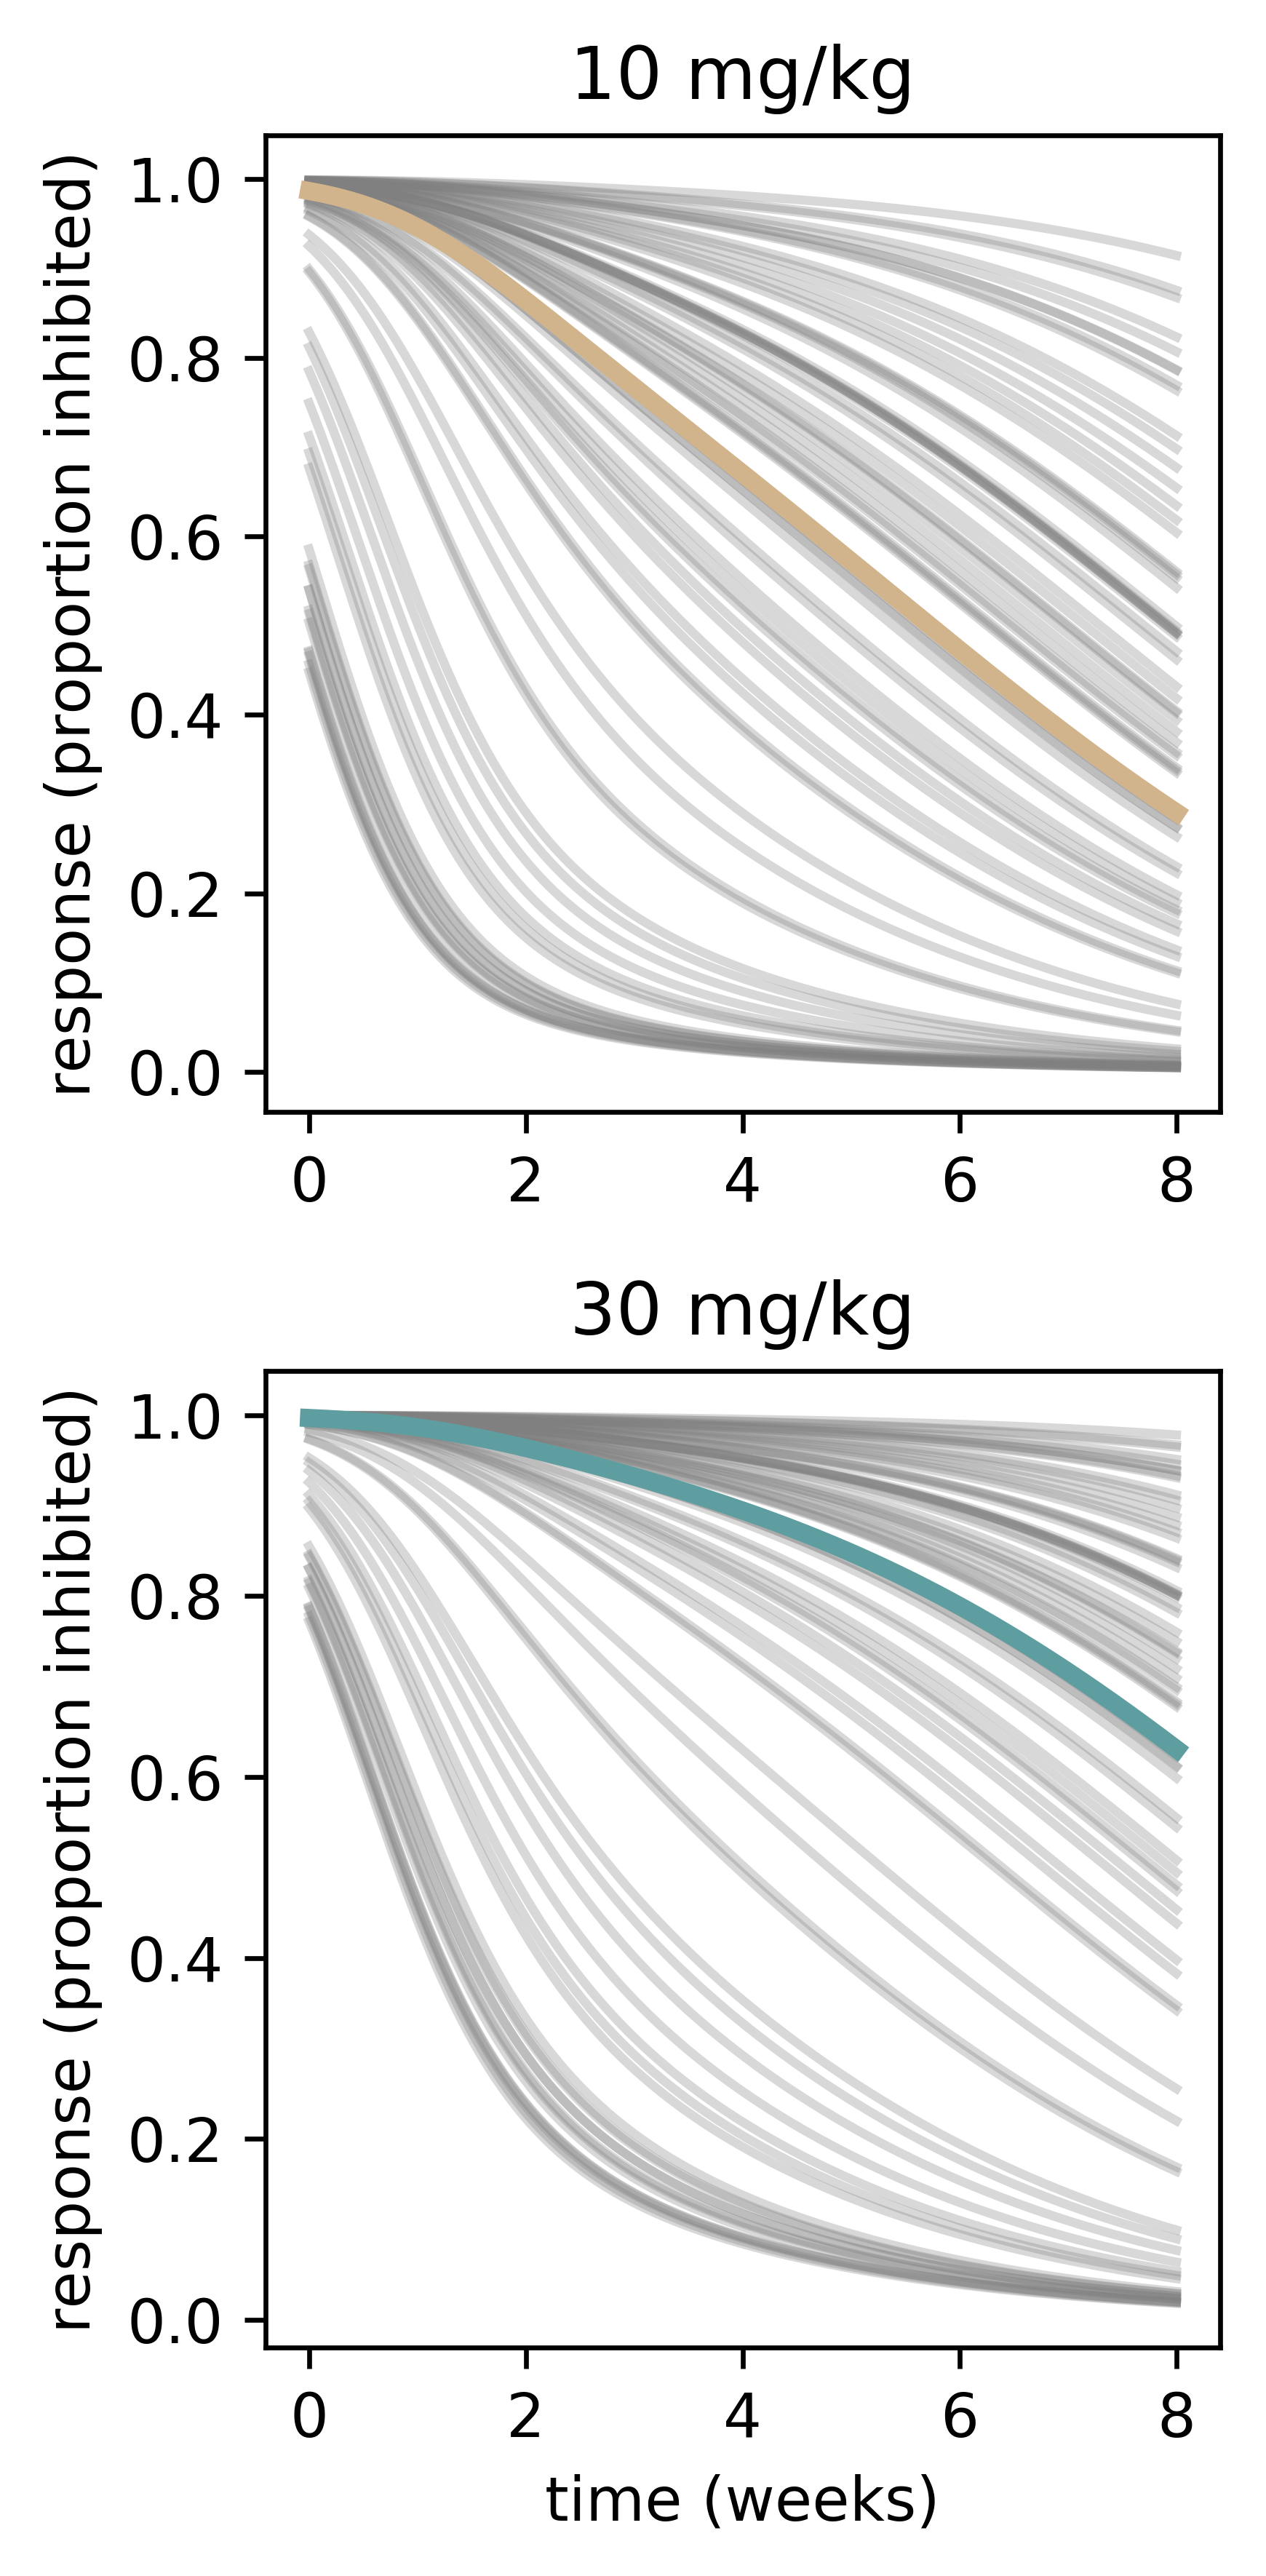

In [7]:
#plot proportion inhibited over time
t=np.linspace(0,8,1e3)
r1=1.5
r2=0.3

plt.figure(figsize=(3,6),dpi=600)

plt.subplot(211)
c1=100; c2=c1/4
Ab=Ab_conc(c1,c2,r1,r2,t)
for i in range(len(log80)):
    plt.plot(t,response80(Ab,10**log80[i]),color='gray',alpha=0.3)    
plt.plot(t,response80(Ab,10**np.median(log80)),color='tan',lw=3)
plt.title('10 mg/kg')
plt.ylabel('response (proportion inhibited)')

plt.subplot(212)
c1=300; c2=c1/4
Ab=Ab_conc(c1,c2,r1,r2,t)
for i in range(len(log80)):
    plt.plot(t,response80(Ab,10**log80[i]),color='gray',alpha=0.3)    
plt.plot(t,response80(Ab,10**np.median(log80)),color='cadetblue',lw=3)
plt.title('30 mg/kg')
plt.ylabel('response (proportion inhibited)')
plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('inhib_time.pdf')  # No warning now


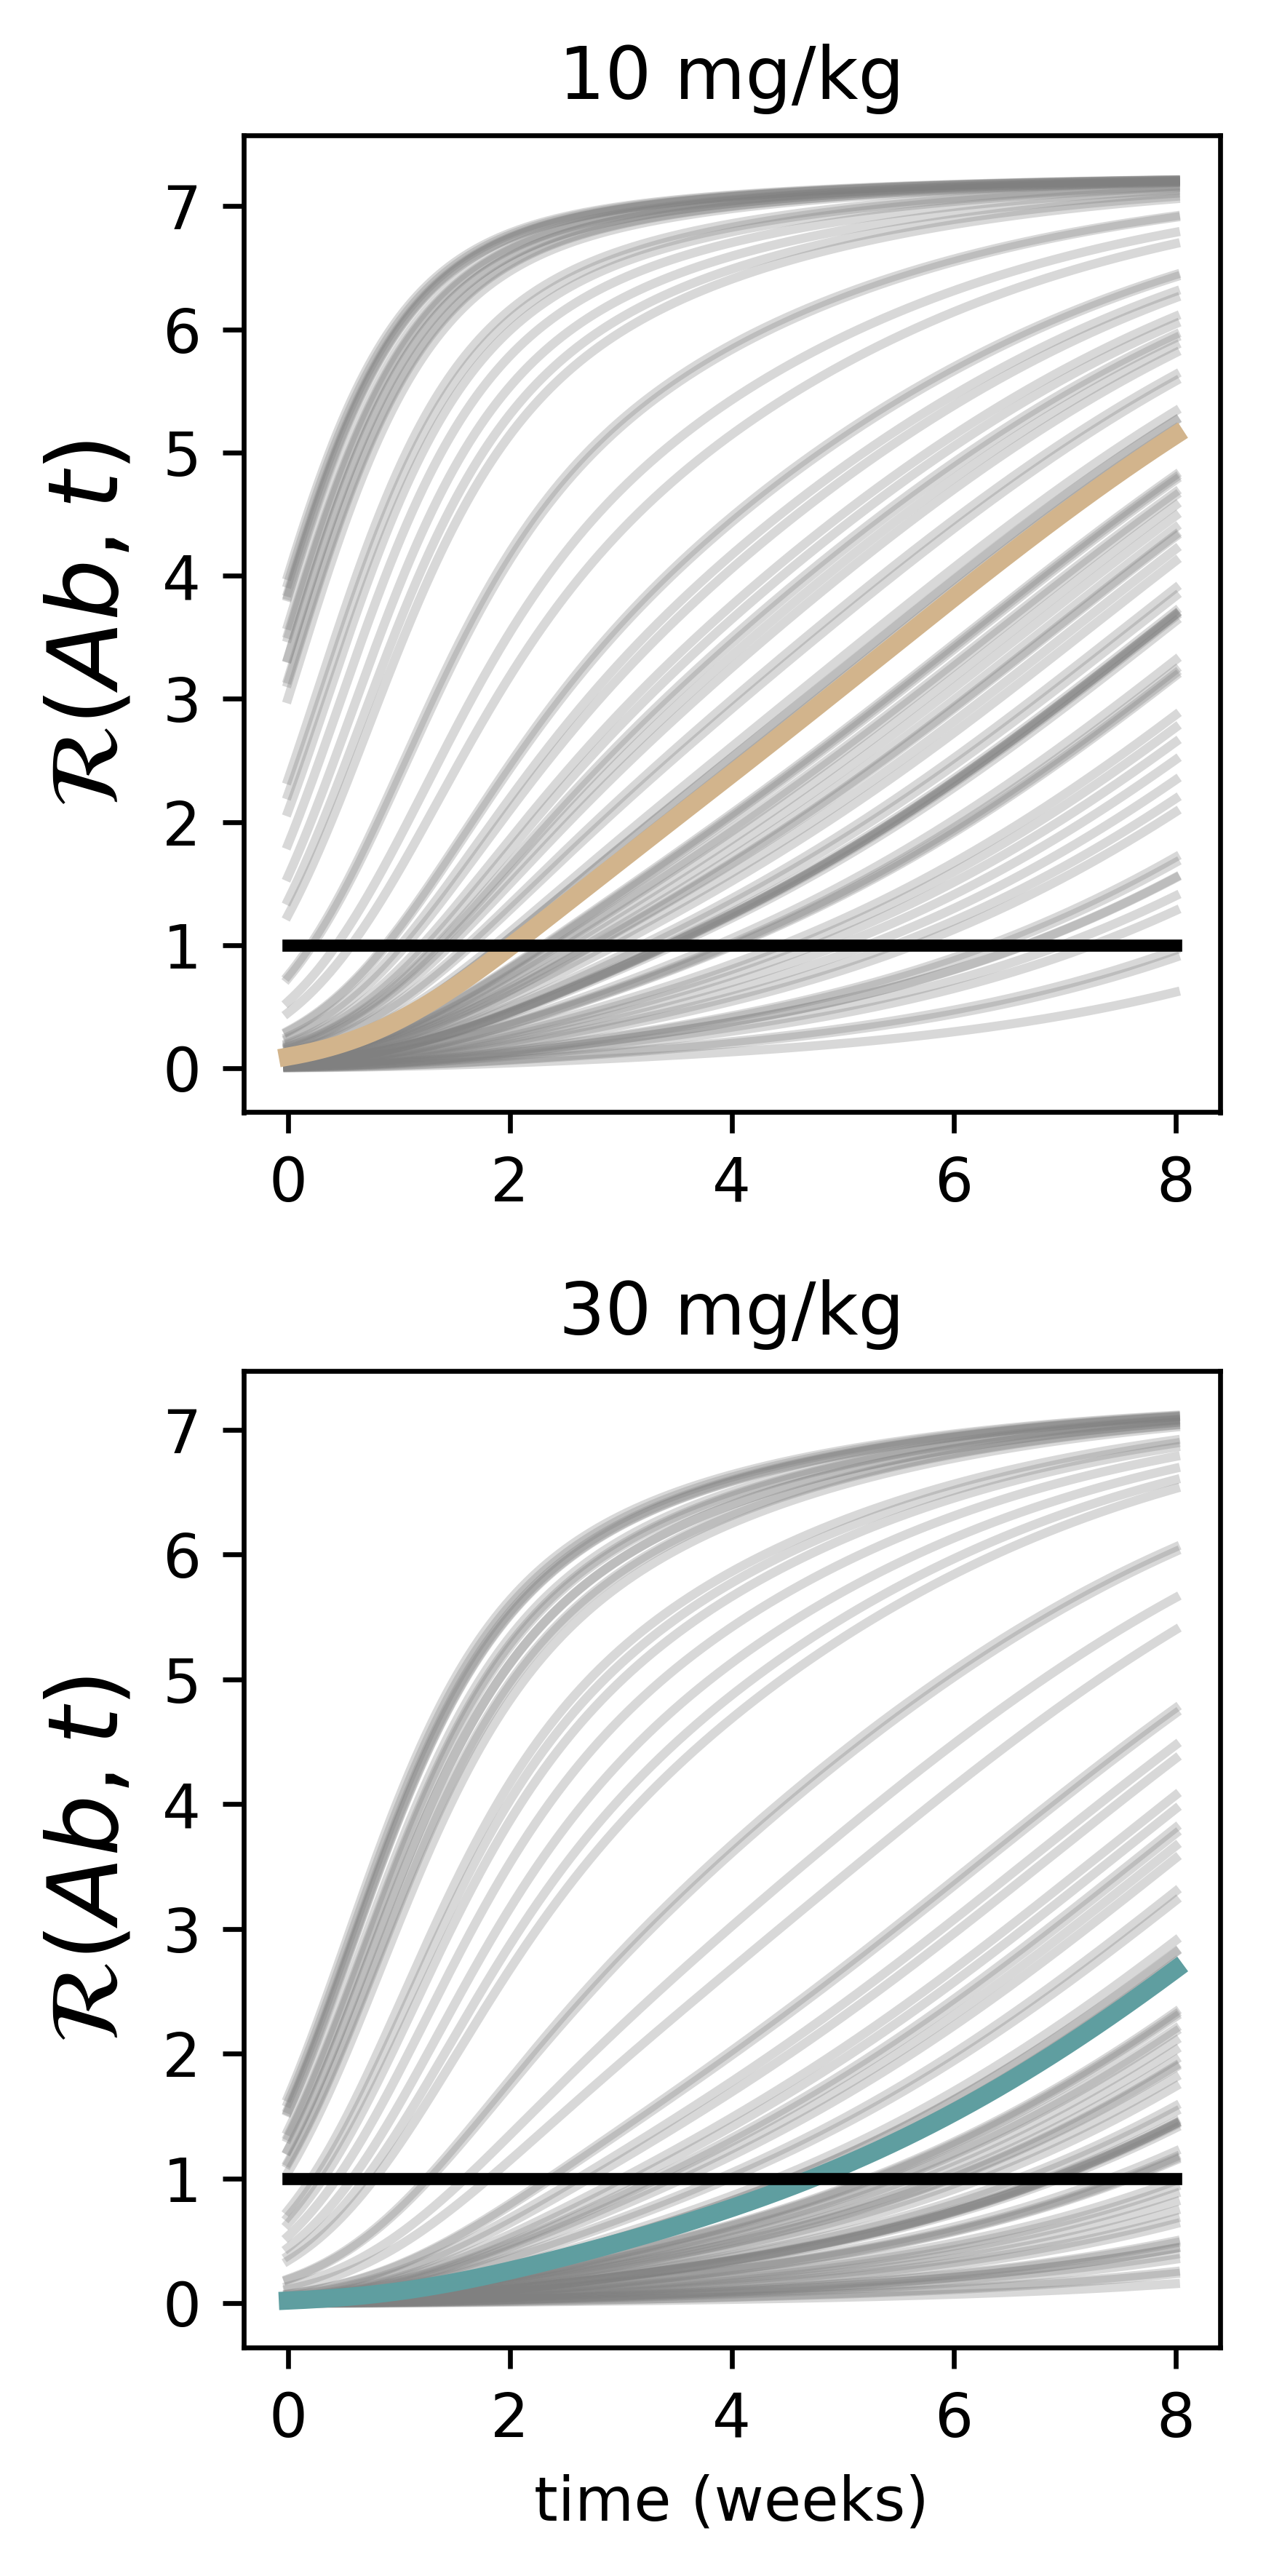

In [8]:
#plot reproductive number over time
t=np.linspace(0,8,1e3)
r1=1.5
r2=0.3

plt.figure(figsize=(3,6),dpi=600)

plt.subplot(211)
c1=100; c2=c1/4
Ab=Ab_conc(c1,c2,r1,r2,t)
for i in range(len(log80)):
    plt.plot(t,R0*(1-response80(Ab,10**log80[i])),color='gray',alpha=0.3)    
plt.plot(t,R0*(1-response80(Ab,10**np.median(log80))),color='tan',lw=3)
plt.plot(t,np.ones(len(t)),color='k',lw=2)
plt.title('10 mg/kg')
plt.ylabel('$\mathcal{R}(Ab,t)$',fontsize=16)

plt.subplot(212)
c1=300; c2=c1/4
Ab=Ab_conc(c1,c2,r1,r2,t)
for i in range(len(log80)):
    plt.plot(t,R0*(1-response80(Ab,10**log80[i])),color='gray',alpha=0.3)    
plt.plot(t,R0*(1-response80(Ab,10**np.median(log80))),color='cadetblue',lw=3)
plt.plot(t,np.ones(len(t)),color='k',lw=2)
plt.title('30 mg/kg')
plt.ylabel('$\mathcal{R}(Ab,t)$',fontsize=16)
plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('R_time.pdf')  # No warning now


In [9]:
#updating the rates of events
num_rates=9; num_states=4; r=np.zeros(num_rates); T=np.zeros([num_rates,num_states])

def update_rates(X,t,Ab0,IC80):
    
    #prop_inhib = response(Ab_conc(Ab0,t%56)) #modulo 8 weeks
    
    dose=Ab_conc(Ab0,Ab0/4,r1,r2,(t%56)/7)

    prop_inhib=response80(dose,IC80)

    Bt=Bt0*(1-prop_inhib) #ab dependent infectivity
    
    S=X[0]; L=X[1]; A=X[2]; V=X[3]
    
    p=np.random.poisson(pi)
    
    r[0] = aS;             T[0][:]=[1,0,0,0];  #constant production 
    r[1] = dS*S;           T[1][:]=[-1,0,0,0]  #density dependent susceptible death
    r[2] = tau*Bt*S*V;     T[2][:]=[-1,1,0,-1] #latent infection
    r[3] = (1-tau)*Bt*S*V; T[3][:]=[-1,0,1,-1] #active infection
    r[4] = dA*A;           T[4][:]=[0,0,-1,p]  #infected cell burst
    r[5] = gam*V;          T[5][:]=[0,0,0,-1]  #density dependent viral clearance
    r[6] = xi*L;           T[6][:]=[0,-1,1,0]  #latent to active
    r[7] = dL*L;           T[7][:]=[0,-1,0,0]  #latent death
    r[8] = aL*L;           T[8][:]=[0,1,0,0]   #homeostatic division proliferation
    
    return r,T #updating the rates of events


#function that solves stochastically using tau-leap method
def bnabs_tauleap(t,Ab0,inc_time,IC80,X0):

    dt=t[1]; x=X0; y=[] #initialize
    for ti in t:
        
        y.append(x) #the list of states

        r,T = update_rates(x,ti,Ab0,IC80) #make new rate vector
        
        E = np.random.poisson(r*dt) #calculate events
        
        dx = np.sum(np.matrix.transpose(T)*E,1) #calculate change in state
        
        x=x+dx #update state variable
        
        if ti==inc_time:
            x[2] = x[2] + 1
 
        x[x<1]=0 #make sure no negative numbers or fractions
        
    return np.array(y)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


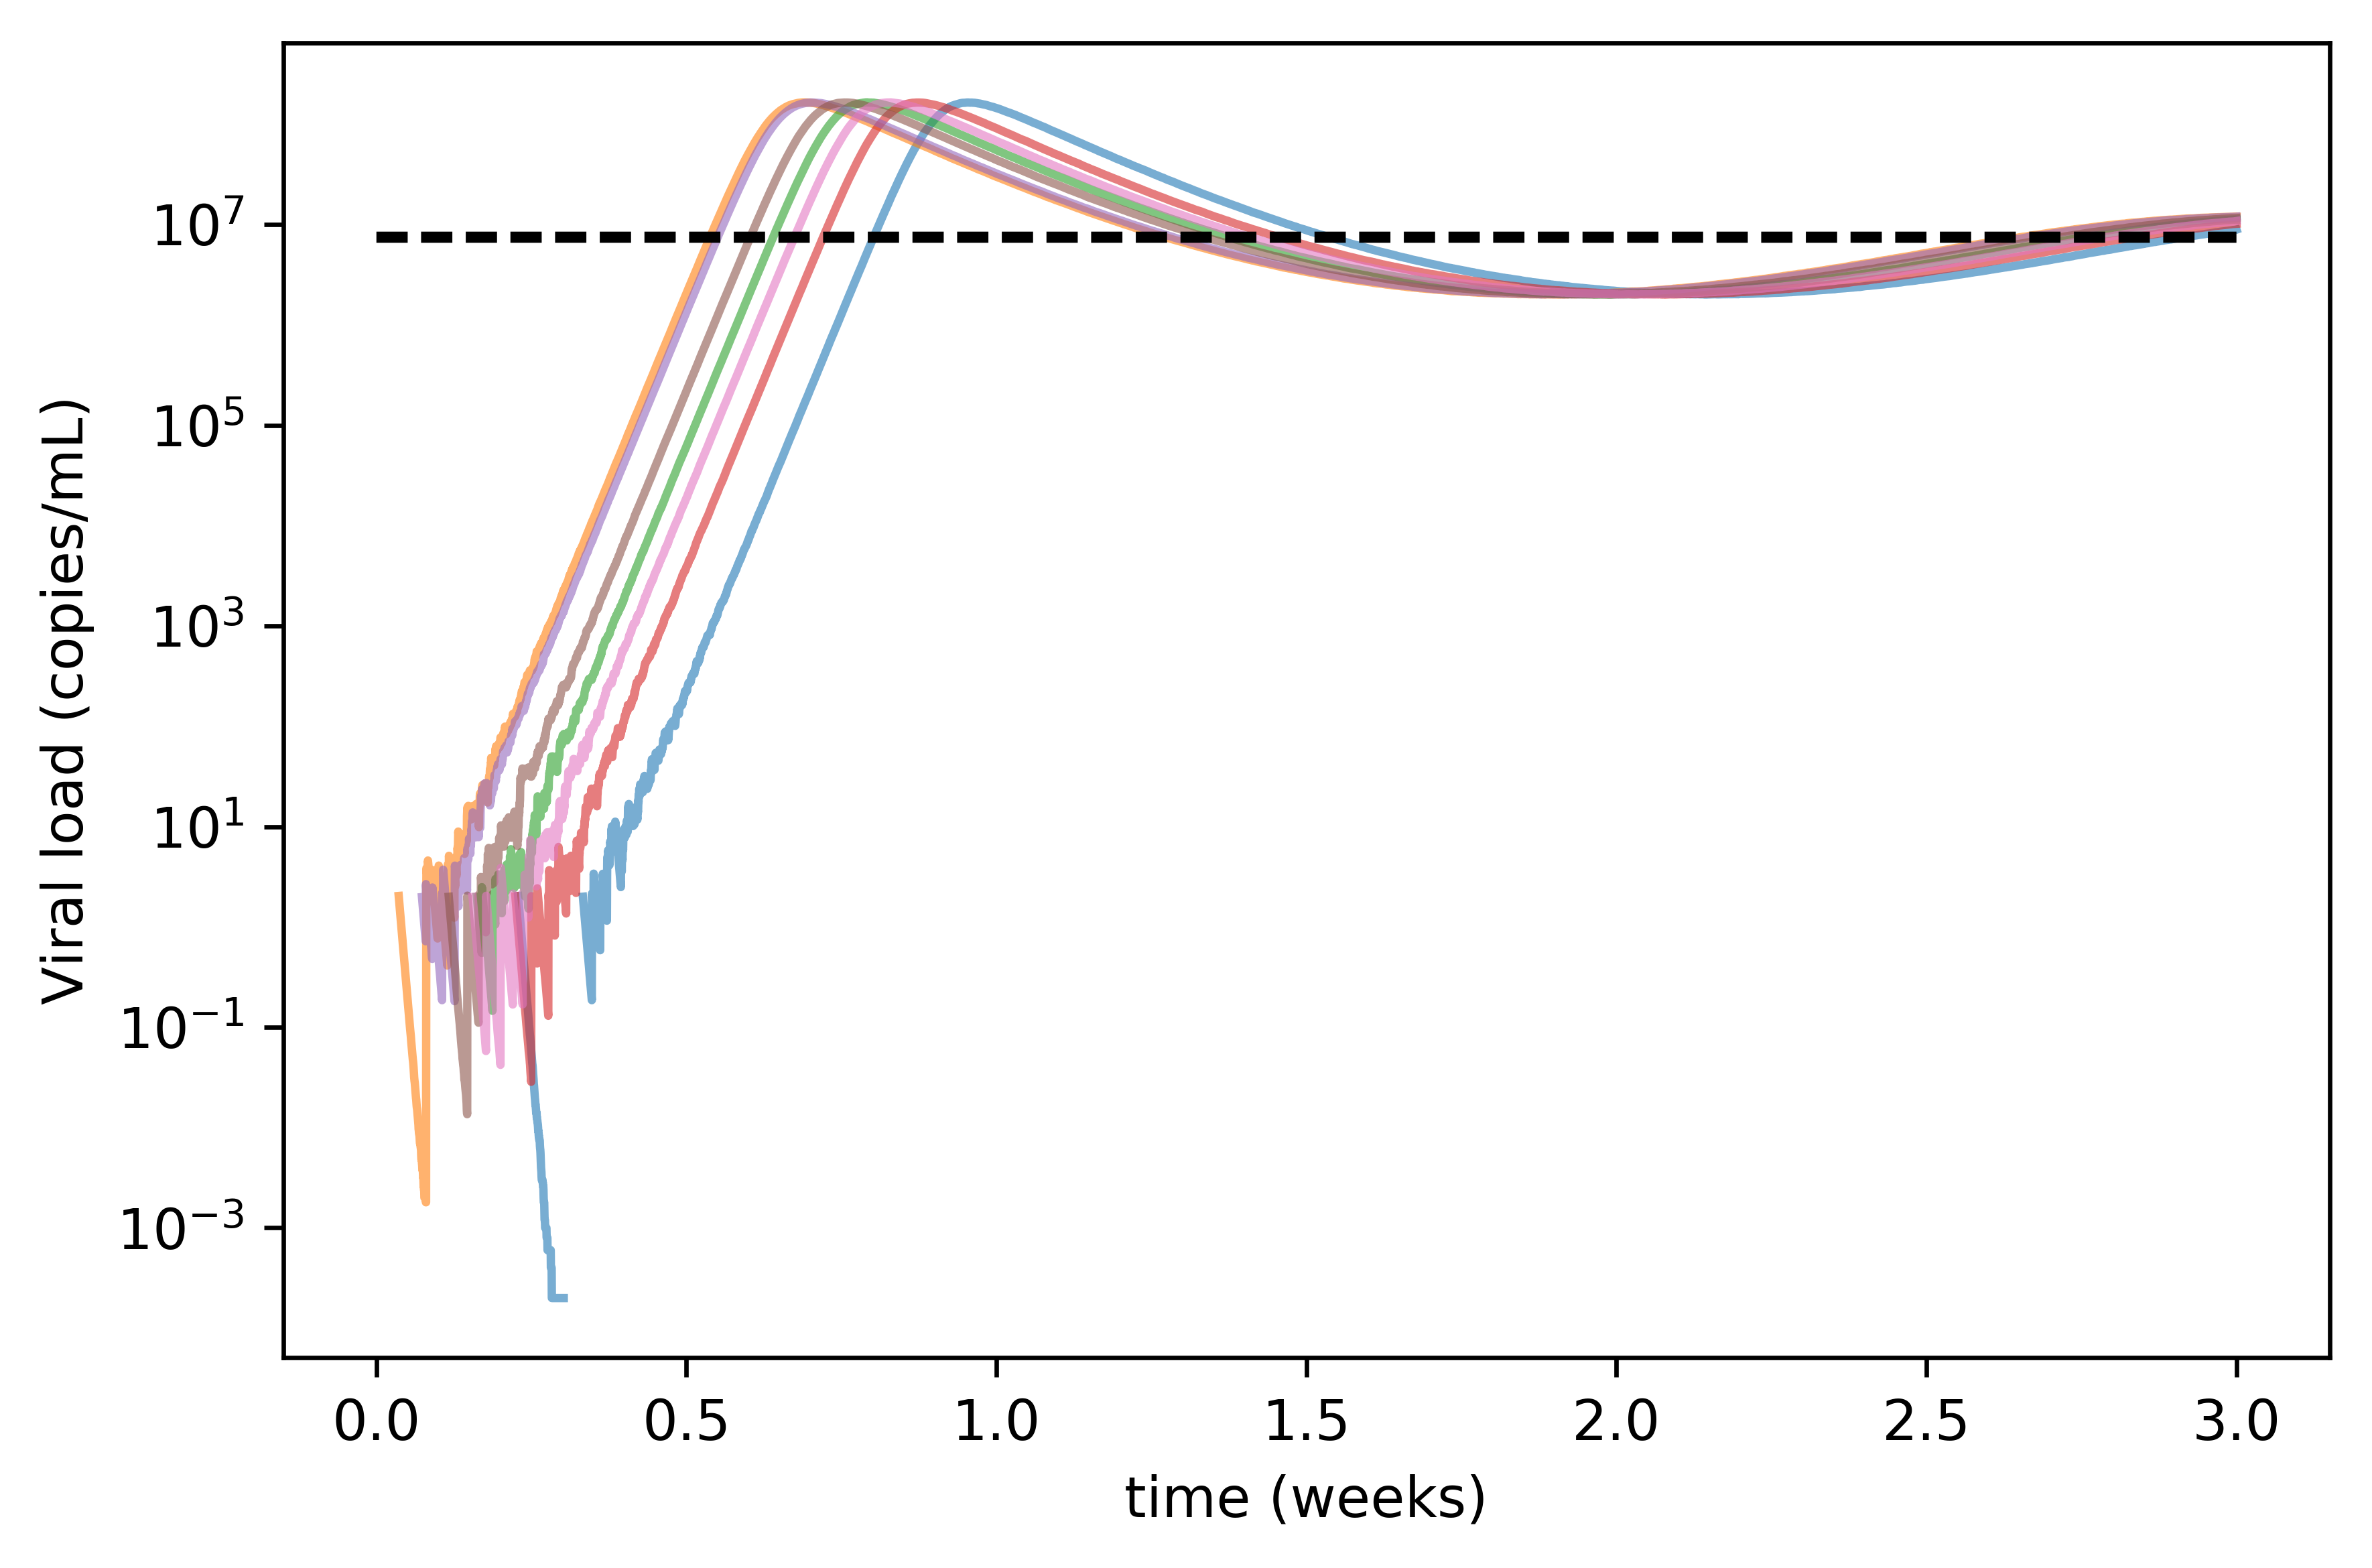

In [13]:
#do a single simulation without antibodies


num_sims=7; 
t=np.linspace(0,3*7,1e4)

x0=np.array([aS/dS,0,0,0]);

plt.figure(figsize=(6,4),dpi=600)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,Ab0=0,inc_time=0,IC80=10**log80[0],X0=x0)
    plt.semilogy(t/7,tlp_sol[:,3]/5e3,alpha=0.6)
    plt.ylabel('Viral load (copies/mL)')

plt.semilogy(t/7,np.ones(len(t))*Veq/5e3,ls='--',lw=2,color='k')

plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('control_R0'+str(R0)+'.pdf')  # No warning now


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


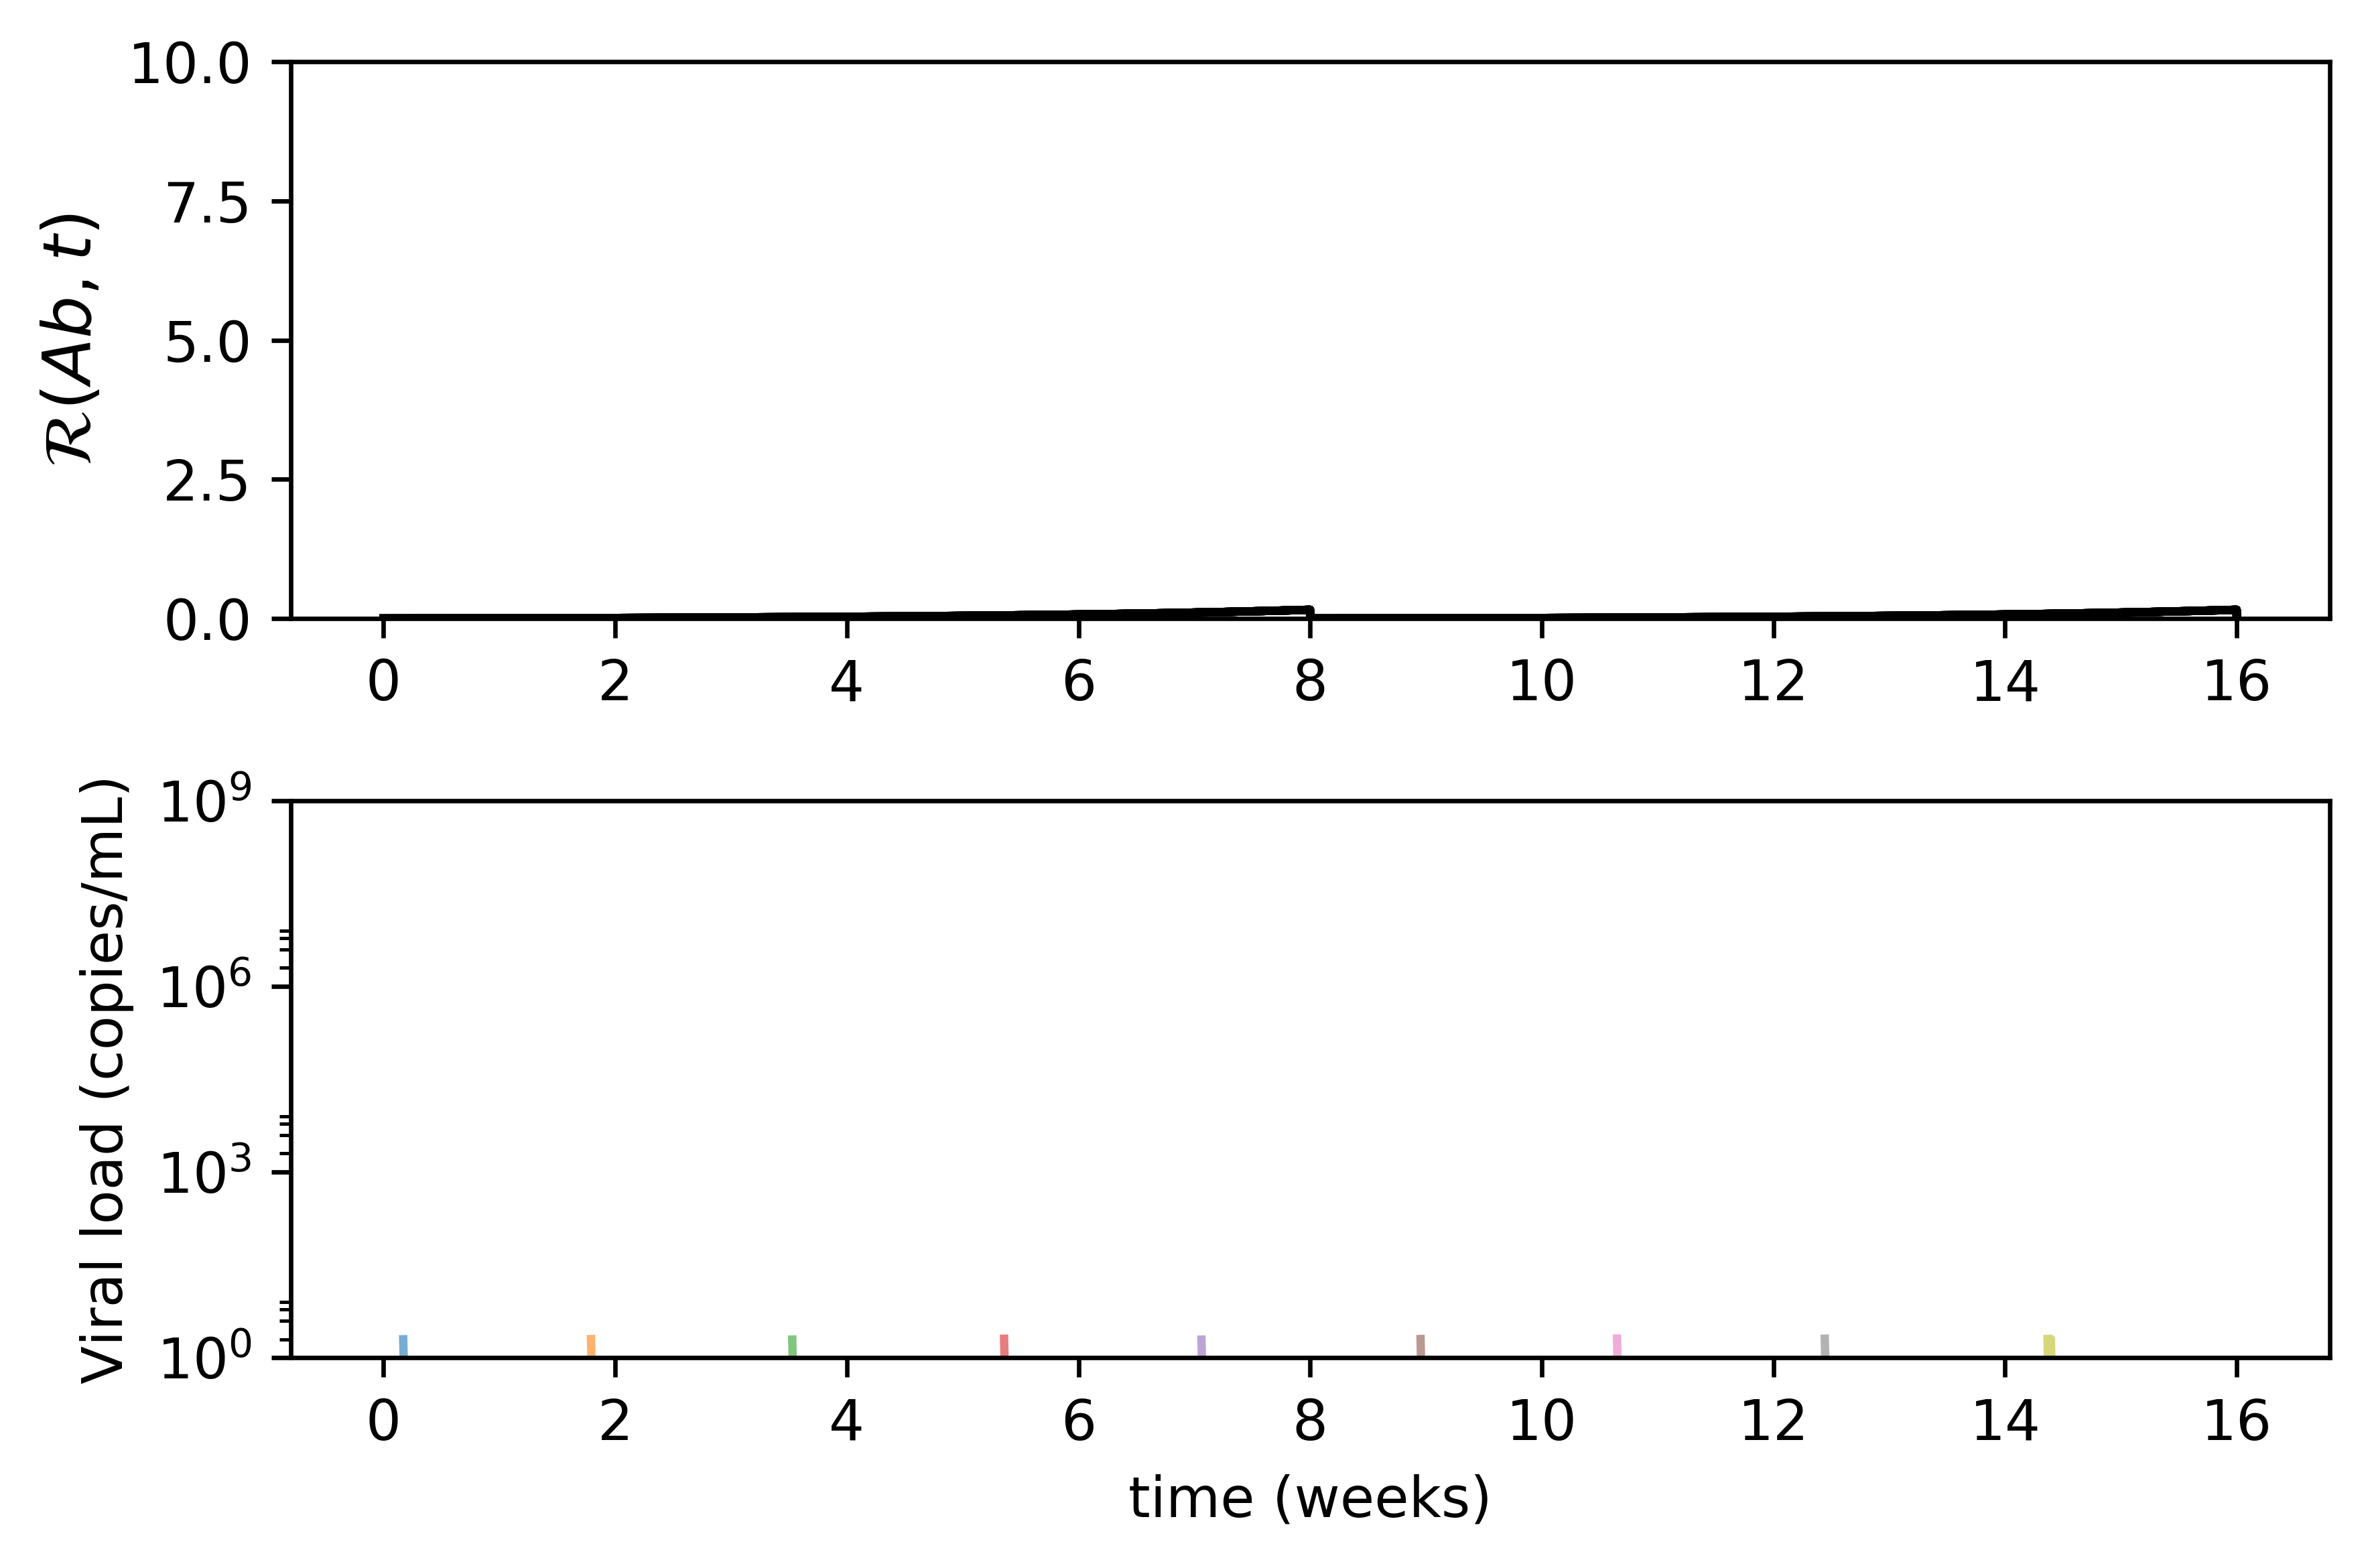

In [14]:
#2 dose simulation

t=np.linspace(0,16*7,1e4) #2 dose curve

#best case scenario for treatment reasons
ic80=10**min(log80); Abc=300 

prop_inhib=response80(dose=Ab_conc(Abc,Abc/4,r1,r2,(t%56)/7),IC80=ic80)
Rt=(1-prop_inhib)*R0 #R0 over time

num_sims=10; 
trial_inds=np.linspace(0,len(t)-100,num_sims)

plt.figure(figsize=(6,4),dpi=600)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,Ab0=Abc,inc_time=t[trial_inds[i]],IC80=ic80,X0=x0)
    plt.subplot(211)
    plt.plot(t/7,Rt,'k')
    plt.ylim([0,10])
    plt.ylabel(r'$\mathcal{R}(Ab,t)$',fontsize=12)
    plt.subplot(212)
    plt.semilogy(t/7,tlp_sol[:,3]/5e3,alpha=0.6)
    plt.ylabel('Viral load (copies/mL)')
    plt.ylim([1,1e9])
plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('10_exposures_best.pdf')  # No warning now


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


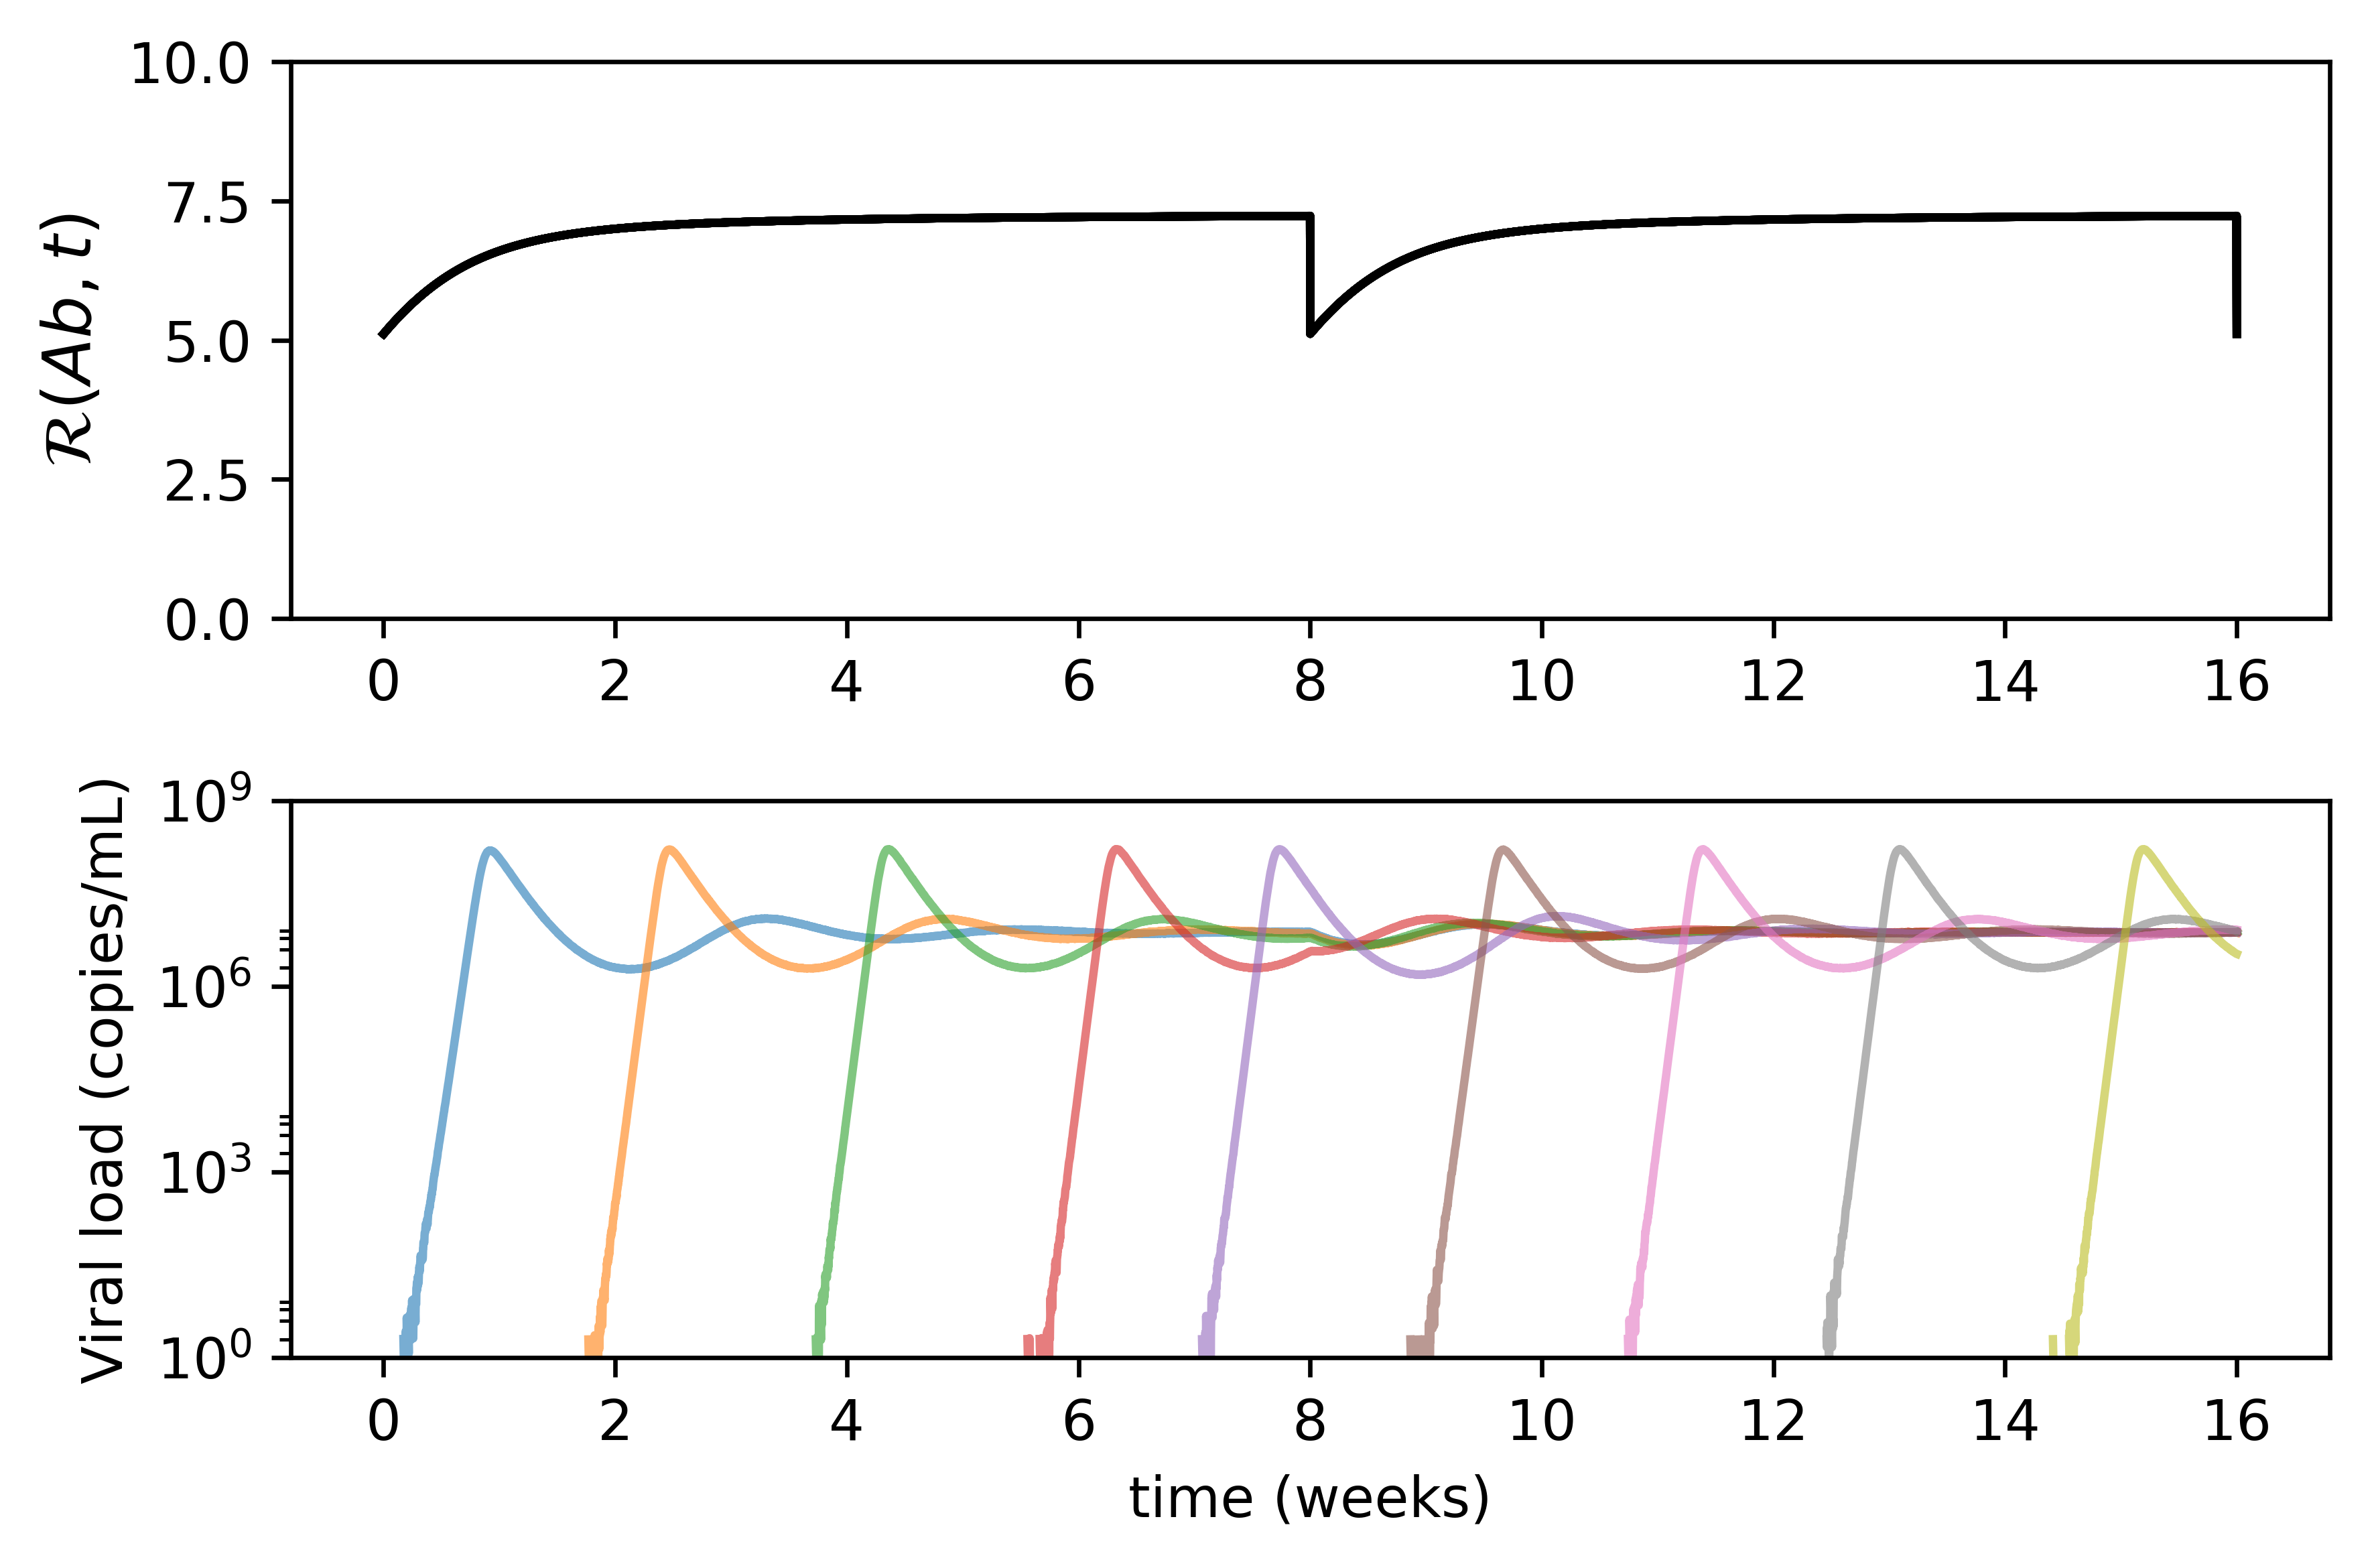

In [15]:

#worst case scenario for treatment reasons
ic80=10**max(log80); Abc=60 
prop_inhib=response80(dose=Ab_conc(Abc,Abc/4,r1,r2,(t%56)/7),IC80=ic80)
Rt=(1-prop_inhib)*R0 #R0 over time

plt.figure(figsize=(6,4),dpi=600)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,Ab0=Abc,inc_time=t[trial_inds[i]],IC80=ic80,X0=x0)
    plt.subplot(211)
    plt.plot(t/7,Rt,'k')
    plt.ylim([0,10])
    plt.ylabel(r'$\mathcal{R}(Ab,t)$',fontsize=12)
    plt.subplot(212)
    plt.semilogy(t/7,tlp_sol[:,3]/5e3,alpha=0.6)
    plt.ylabel('Viral load (copies/mL)')
    plt.ylim([1,1e9])
plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('10_exposures_worst.pdf')  # No warning now



/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


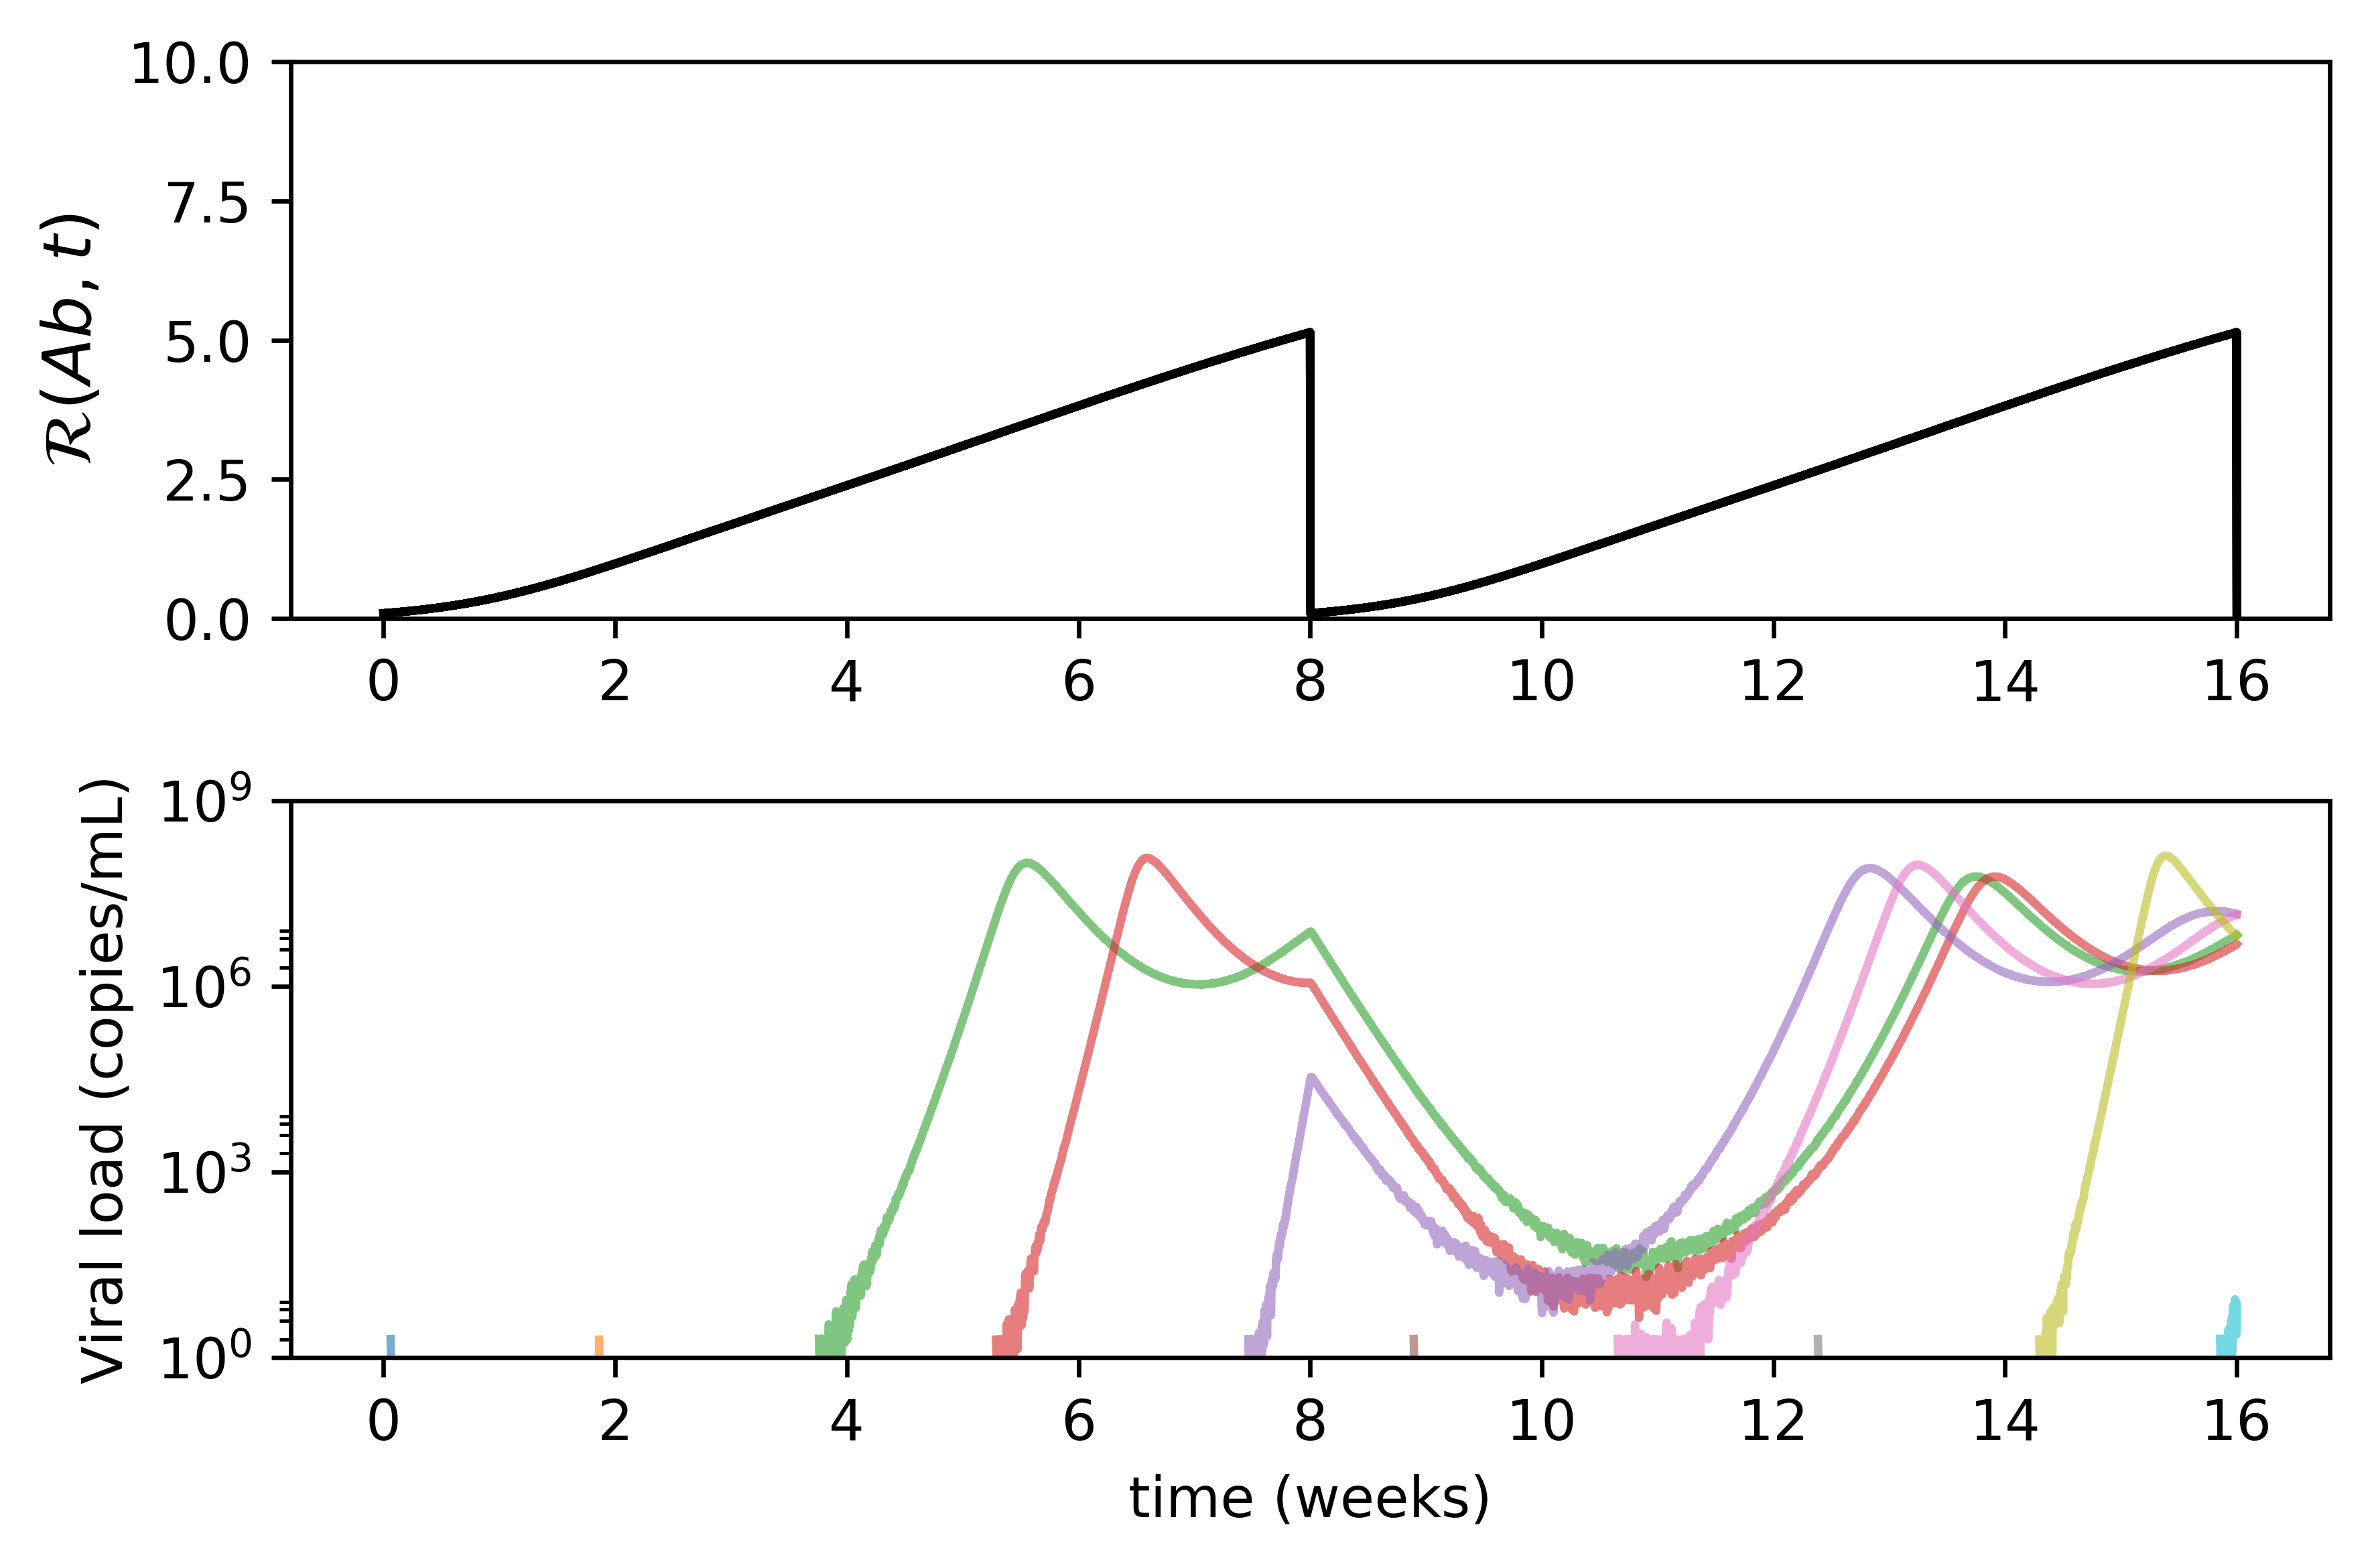

In [16]:
#more realistic scenario
ic80=10**np.median(log80); Abc=100 
prop_inhib=response80(dose=Ab_conc(Abc,Abc/4,r1,r2,(t%56)/7),IC80=ic80)
Rt=(1-prop_inhib)*R0 #R0 over time

plt.figure(figsize=(6,4),dpi=600)
for i in range(num_sims):
    tlp_sol = bnabs_tauleap(t,Ab0=Abc,inc_time=t[trial_inds[i]],IC80=ic80,X0=x0)
    plt.subplot(211)
    plt.plot(t/7,Rt,'k')
    plt.ylim([0,10])
    plt.ylabel(r'$\mathcal{R}(Ab,t)$',fontsize=12)
    plt.subplot(212)
    plt.semilogy(t/7,tlp_sol[:,3]/5e3,alpha=0.6)
    plt.ylabel('Viral load (copies/mL)')
    plt.ylim([1,1e9])
plt.xlabel('time (weeks)')

plt.tight_layout()
plt.gcf().savefig('10_exposures_med.pdf')  # No warning now


In [17]:
#run each simulation num times

trial_days = 80*7

t_trial=np.linspace(0,trial_days,1e4) #80 week trial

trial_names=['msm10','msm30','msmc','w10','w30','wc']
inc_rate = [3.,3.,3.,5.,5.,5.] #percent incidence per year
size=[800,800,800,500,500,500]
Ab0_list=[80,200,0,80,200,0]
clist=['tan','cadetblue','k','tan','cadetblue','k']

In [85]:
t_trial[obs]

array([ 0.])

In [71]:
#actually simulate the trials
trial_data=[]; incidences=[]; IC80_counter=[]; Ab0_counter=[]; R_counter=[];
trial=0
for trial in range(len(trial_names)):
    
    #get rare events!
    avg_inc = inc_rate[trial]/100/365*t_trial[-1] #the average over whole trial
    inc_list = np.random.poisson(avg_inc,size[trial]) #list of incidences
    real_inc = inc_list[inc_list>0] #list where incidence>0

    print('there were '
          + str(len(real_inc))
          + ' individuals with '
          + str(np.sum(real_inc)) 
          + ' incidences in trial '
          + trial_names[trial])
    
    incidences.append(len(real_inc))
    
    #only loop over real exposed participants
    V_tot=[]
    for i in range(len(real_inc)):
        
        incx = np.round(np.random.random_sample((real_inc[i],))*len(t_trial)) #get n random indices for each person with n incidences

        #first solve
        Ab0=np.random.poisson(Ab0_list[trial]) #random Ab infusions for trial
        
        inc_time = t_trial[int(incx[0])] #get each incidence time
        
        #keep track of Ab conc at incidence time
        dose_at_inc = Ab_conc(Ab0,Ab0/4,r1,r2,(inc_time%56)/7)        
        Ab0_counter.append(dose_at_inc)

        #keep track of IC80 of infecting virus
        IC80=np.random.choice(10**log80)
        IC80_counter.append(IC80)
        
        #reproductive number at incidence
        prop_inhib=response80(dose=dose_at_inc,IC80=IC80)
        R_counter.append((1-prop_inhib)*R0) #R0 over time

        tlp_sol = bnabs_tauleap(t_trial,Ab0=Ab0,inc_time=inc_time,IC80=IC80,X0=x0) #solve model with random IC80 from all possible
        
        V=tlp_sol[:,3]/5e3 #add each exposure VL 
        
        #loop over each exposure per participants (some have more than 1!)
        #if len(incx)>1:
        #    for i in range(len(incx)-1):
        #        tlp_sol = bnabs_tauleap(t,Ab0=Ab0,inc_time=inc_time,IC80=np.random.choice(10**log80),X0=tlp_sol[int(incx),:]) #solve with new initial conditions based on previous
        #        V=V+tlp_sol[:,3]/5e3 #add each exposure VL 
        V_tot.append(V)
    
    trial_data.append(V_tot)
    

there were 27 individuals with 28 incidences in trial msm10
there were 33 individuals with 34 incidences in trial msm30
there were 32 individuals with 33 incidences in trial msmc


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


there were 42 individuals with 46 incidences in trial w10
there were 27 individuals with 27 incidences in trial w30
there were 34 individuals with 36 incidences in trial wc


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


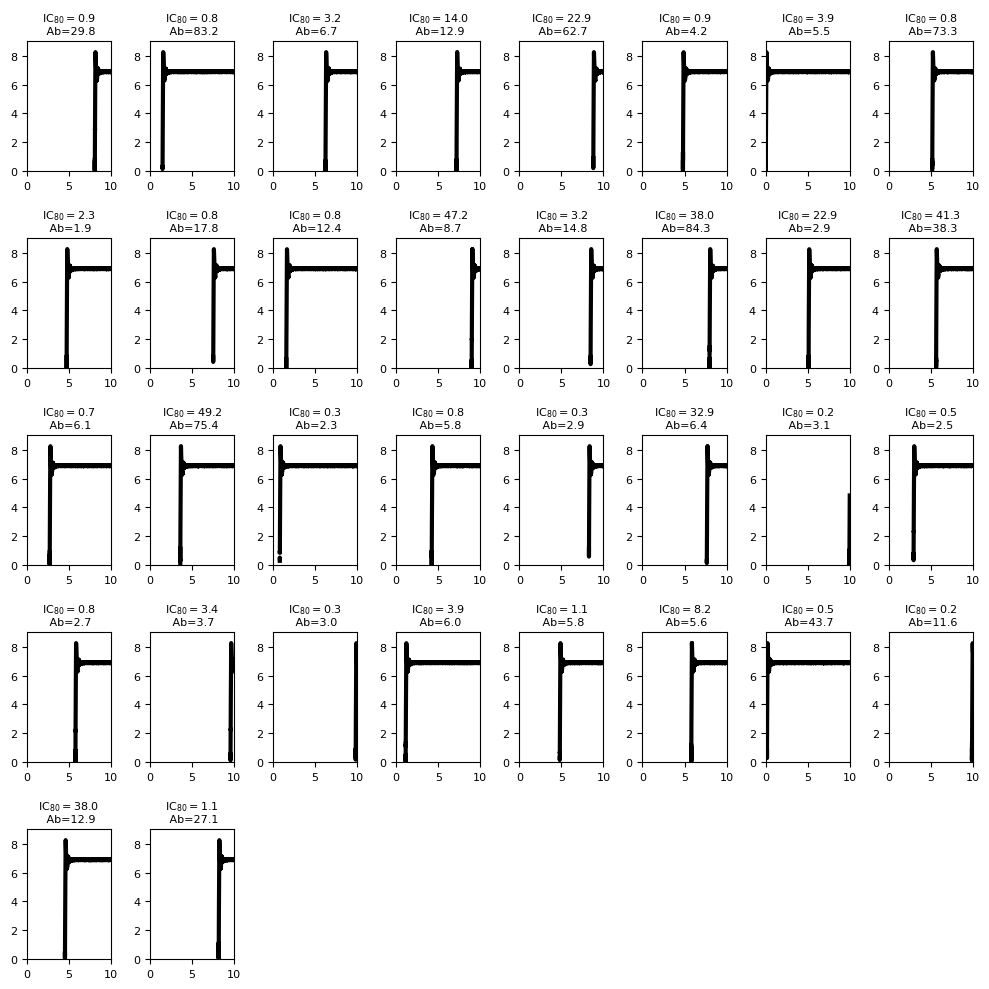

In [72]:
exposed_ppts = len(trial_data[trial])
plt.figure(figsize=(10,10),dpi=100)
for j in range(exposed_ppts):
    plt.subplot(5,8,j+1)
    plt.plot(t_trial/7/8,np.log10(trial_data[trial][j]),color=clist[trial],lw=3) #plot log10(V)
    plt.title('IC$_{80}=$'+str(round(IC80_counter[j],1))+'\n Ab='+str(round(Ab0_counter[j],1)),fontsize=8)
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.xlim([0,t_trial[len(t_trial)-1]/7/8])
    plt.ylim([0,9])

plt.tight_layout()
plt.savefig(trial_names[trial]+'.pdf')  # No warning now


In [78]:
#calculate statistics on all trials

for trial in [len(trial_names)-1]:#range(len(trial_names)):
    virus_at_end = np.array(trial_data[trial])[:,len(t)-1]
    virus_at_end_yes = np.array(trial_data[trial])[:,len(t)-1]>0

    x=virus_at_end_yes
    y1=Ab0_counter
    y2=IC80_counter

    slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x,y1)
    slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x,y2)

    xx=np.linspace(0,1,1e3)

    plt.figure(figsize=(7,3),dpi=600)

    plt.subplot2grid((1, 4), (0, 0), colspan=1)
    plt.scatter(virus_at_end_yes,Ab0_counter,color=clist[trial],s=50,marker='o')
    plt.plot(xx,intercept1+slope1*xx,color='k',lw=3)
    #plt.yscale('log')
    plt.title('p='+str(round(p_value1,2)),fontsize=10)
    plt.xticks([0,1],['virus -','virus +'])
    plt.xlim([-0.2,1.2])
    plt.ylabel('Ab conc \n at incidence ($\mu$g/$\mu$L)')

    plt.subplot2grid((1, 4), (0, 1), colspan=1)
    plt.scatter(virus_at_end_yes,IC80_counter,color=clist[trial],s=50,marker='>')
    #plt.yscale('log')
    plt.plot(xx,intercept2+slope2*xx,color='k',lw=3)
    plt.title('p='+str(round(p_value2,4)),fontsize=10)
    plt.xlim([-0.2,1.2])
    plt.xticks([0,1],['virus -','virus +'])
    plt.ylabel('IC$_{80}$ of virus ($\mu$g/$\mu$L)')

    plt.subplot2grid((1, 4), (0, 2), colspan=2)
    plt.scatter(y1,y2,s=virus_at_end_yes*100,color=clist[trial],marker='+')
    plt.scatter(y1,y2,s=np.abs(virus_at_end_yes-1)*10,color=clist[trial],marker='.')
    plt.xscale('log')
    plt.yscale('log')

    plt.legend(['virus +','virus -'],fontsize=8,loc=4)
    plt.xlabel('Ab conc at incidence ($\mu$g/$\mu$L)')
    plt.ylabel('IC$_{80}$ of virus ($\mu$g/$\mu$L)')

    plt.tight_layout()

    plt.savefig(trial_names[trial]+'_corr.pdf')

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [21]:
x=virus_at_end_yes
y=Ab0_counter

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

slope

-44.244167850176602

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


IndexError: list index out of range

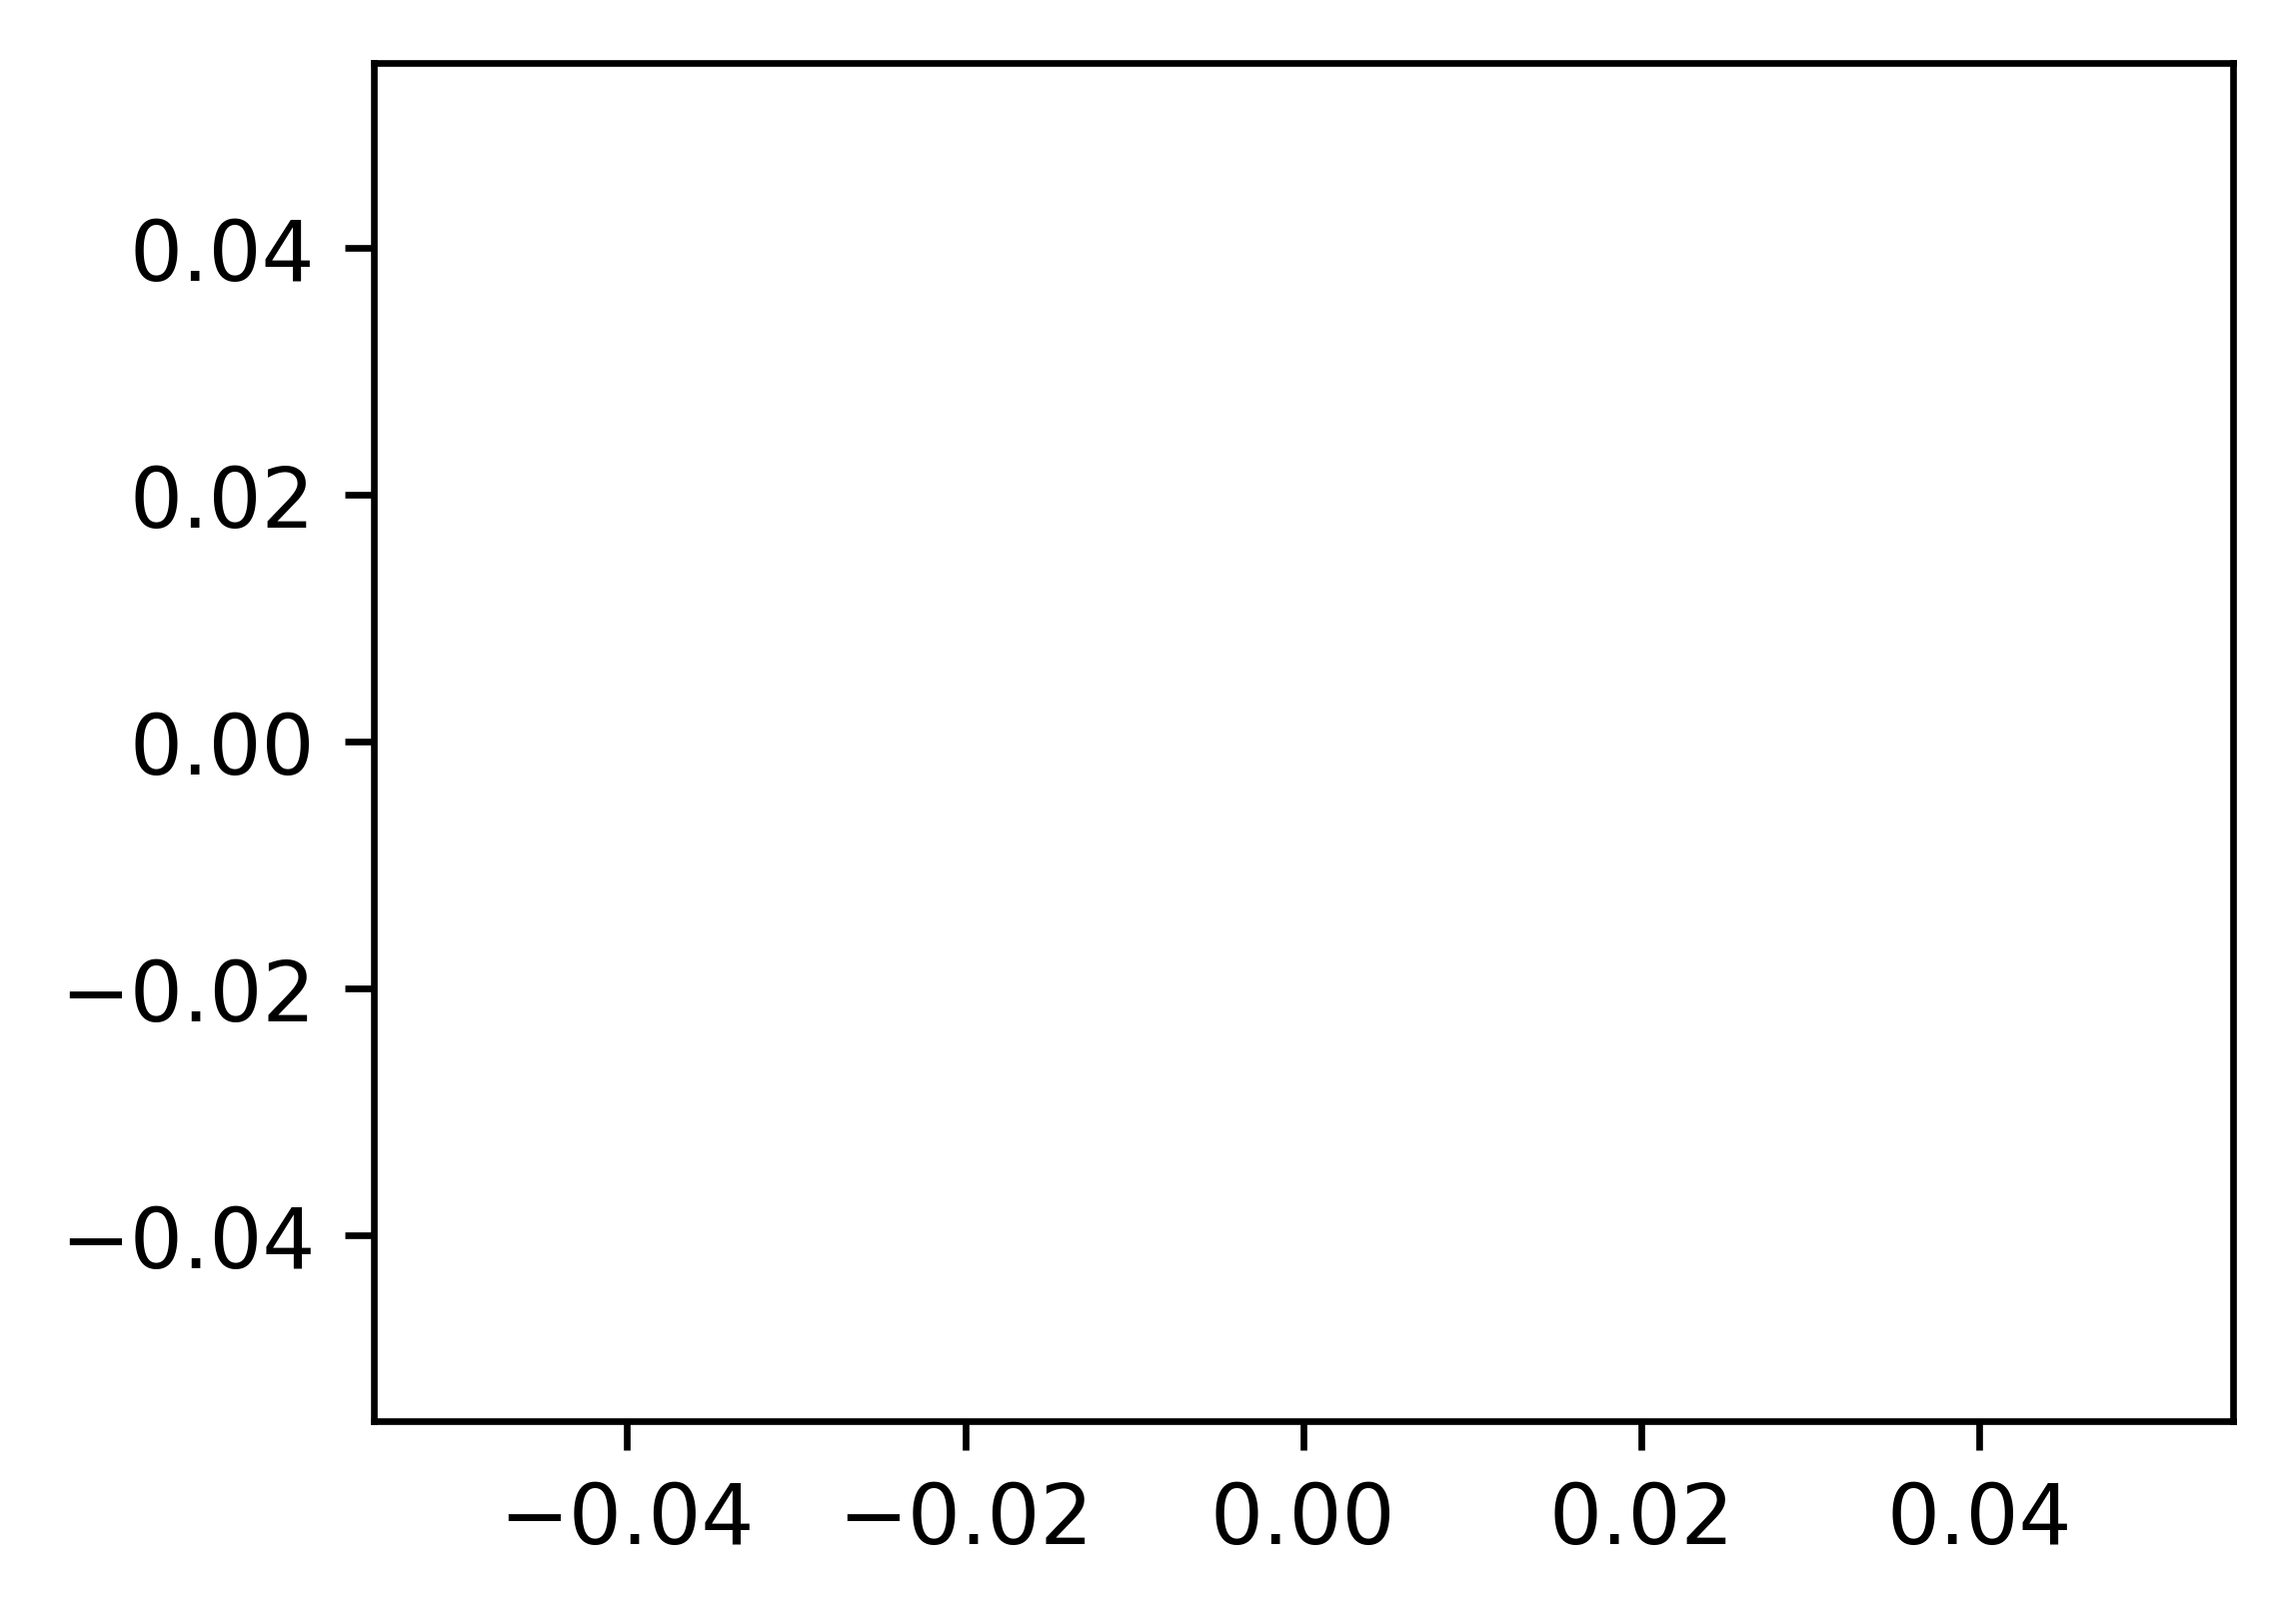

In [81]:
for trial in range(len(trial_names)):

    #plot viral loads at all visits
    obs=range(0,len(trial_data[trial][0][obs]),500)
    plt.figure(figsize=(4,3),dpi=600)

    for j in range(exposed_ppts):
        plt.scatter(t_trial[obs]/7/4,np.log10(trial_data[trial][j][obs]),color=clist[trial],lw=1,alpha=0.5) #plot log10(V)            

    plt.xlim([0,20])
    plt.ylim([0,9])

    plt.tight_layout()
    plt.ylabel('viral load $\log_{10}$(copies/mL)')
    plt.xlabel('visit number')

    plt.tight_layout()
    plt.savefig(trial_names[k]+'_observed.pdf')  # No warning now

    

In [57]:
np.sum(np.array(trial_data[trial])[:,obs]>30,0)

array([ 0,  1,  1,  1,  2,  4,  7,  6, 10,  9, 12, 11, 12, 12, 13, 12, 15,
       17, 19, 18])

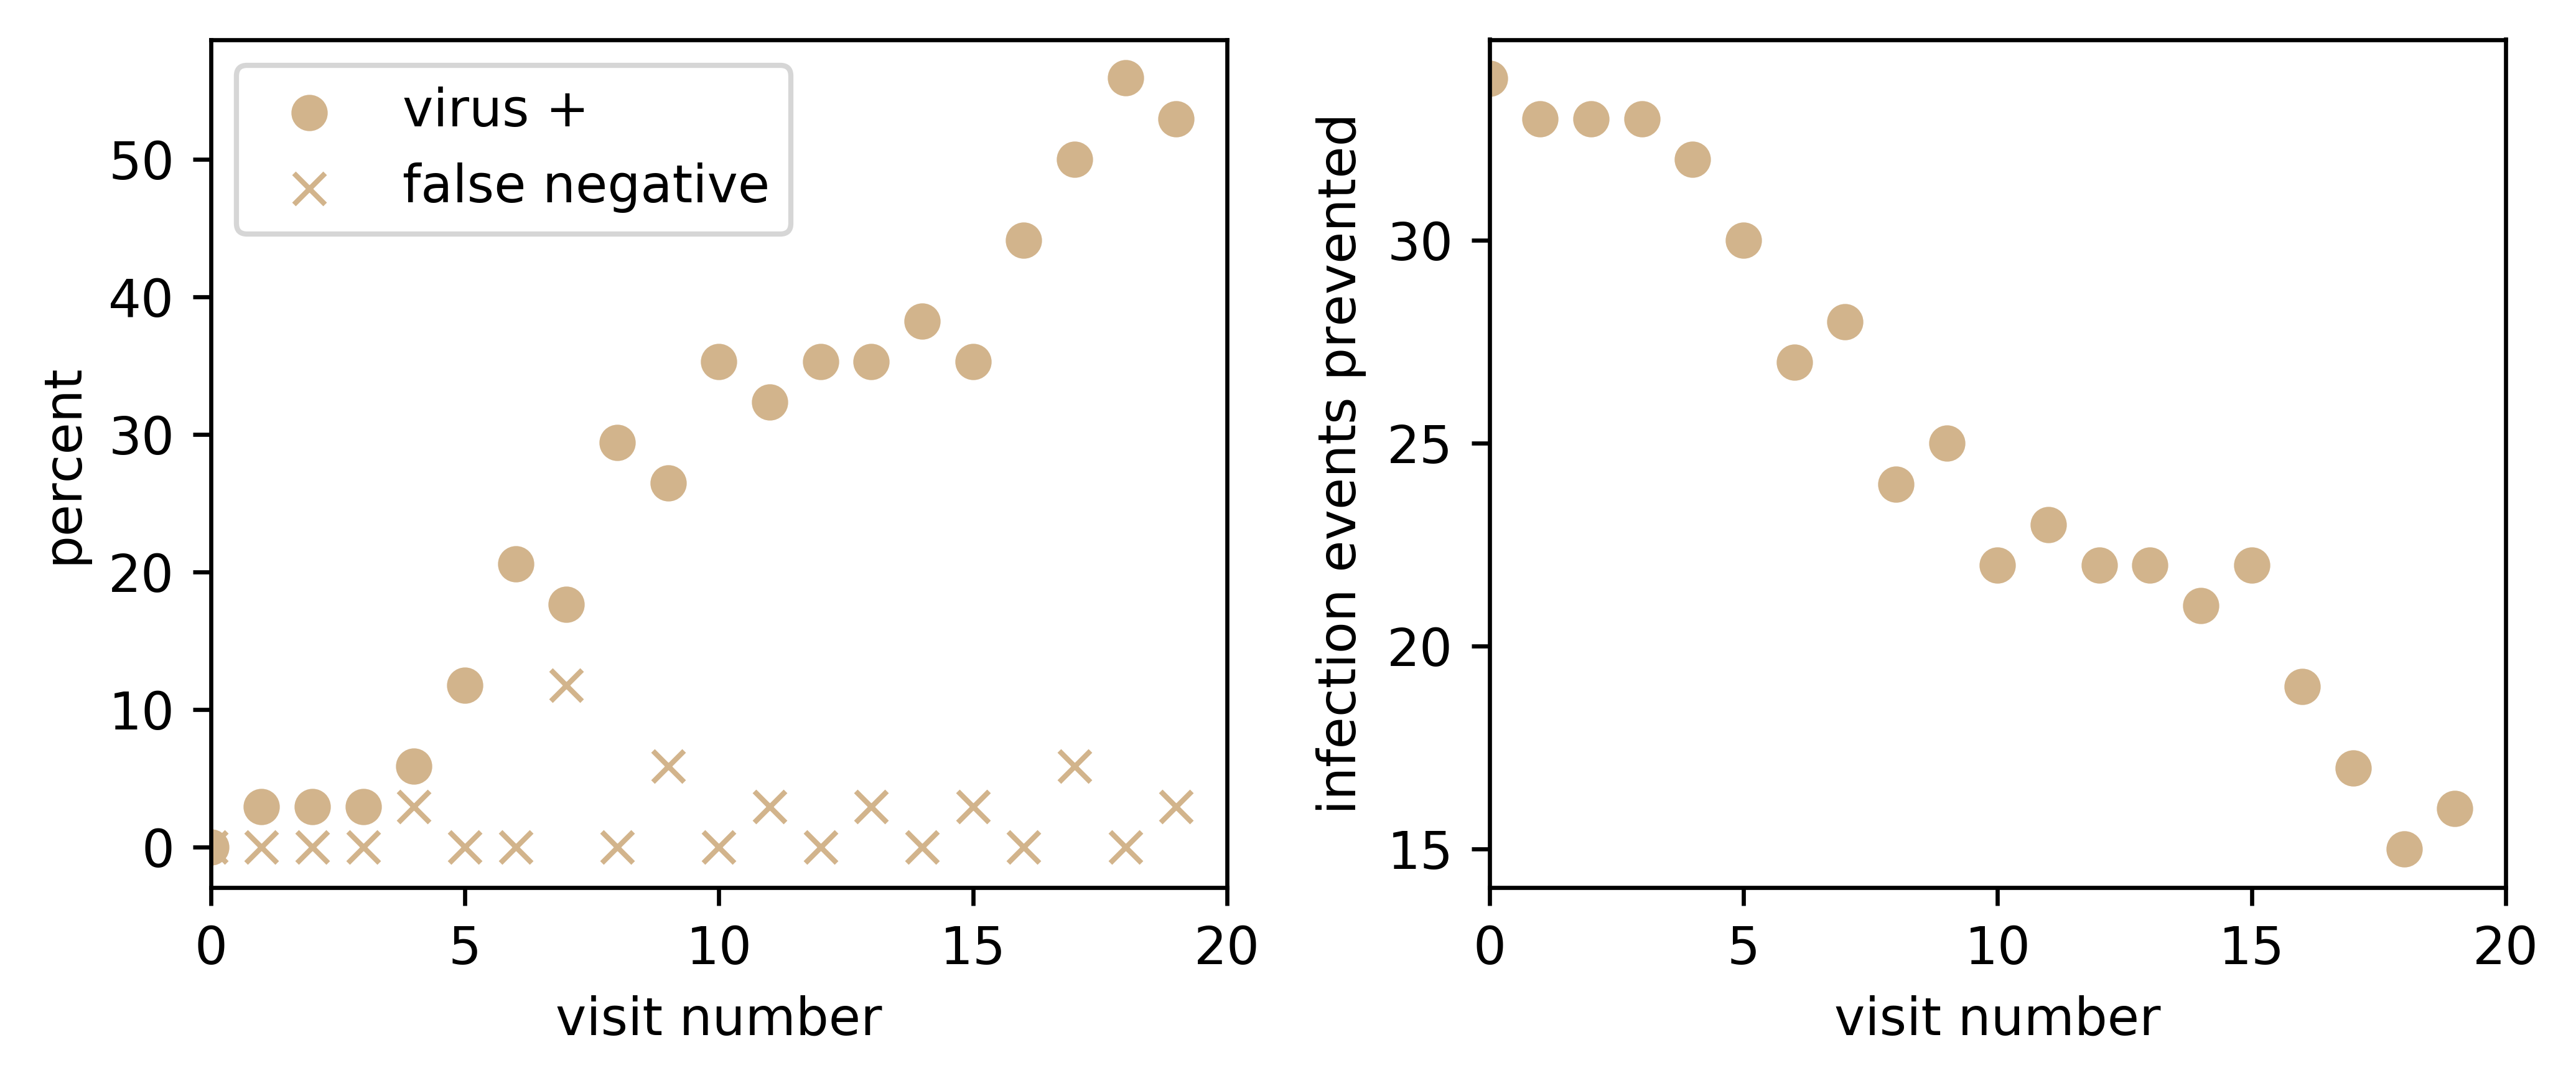

In [70]:
#plot percent positive at all visits
obs=range(0,len(t_trial),500)
plt.figure(figsize=(7,3),dpi=600)

pos=np.sum(np.array(trial_data[trial])[:,obs]>30,0)

low=np.sum(np.array(trial_data[trial])[:,obs]>0,0)

plt.subplot(121)
plt.scatter(t_trial[obs]/7/4,pos/exposed_ppts*100,color=clist[trial],lw=1) #plot log10(V)            
plt.scatter(t_trial[obs]/7/4,(low-pos)/exposed_ppts*100,color=clist[trial],lw=1,marker='x') #plot log10(V)            
plt.ylabel('percent')
plt.xlabel('visit number')

plt.legend(['virus +','false negative'])
plt.xlim([0,20])

plt.subplot(122)
plt.scatter(t_trial[obs]/7/4,exposed_ppts-pos,color=clist[trial],lw=1) #plot log10(V)            
plt.ylabel('infection events prevented')
plt.xlabel('visit number')
plt.xlim([0,20])

plt.tight_layout()
plt.savefig(trial_names[k]+'_pctpos.pdf')  # No warning now
    

In [ ]:
#fraction protected (vaccine efficacy??)
plt.figure(figsize=(4,3),dpi=600)

pos=np.sum(np.array(trial_data[trial])[:,obs]>30,0)

low=np.sum(np.array(trial_data[trial])[:,obs]>0,0)

plt.scatter(t_trial[obs]/7/4,pos/exposed_ppts*100,color=clist[trial],lw=1) #plot log10(V)            
plt.scatter(t_trial[obs]/7/4,(low-pos)/exposed_ppts*100,color=clist[trial],lw=1,marker='x') #plot log10(V)            
plt.ylabel('percent')
plt.xlabel('visit number')

plt.legend(['virus +','false negative'])

plt.xlim([0,20])
#lt.ylim([0,9])

plt.tight_layout()
plt.savefig(trial_names[k]+'_pctpos.pdf')  # No warning now
    